## Supplementary Analysis of the Influence of Campaign Contributions and Incumbency on the Outcome of the 2016 House of Representatives Election Cycle Including Vote Count and Vote Share

In [1]:
from warnings import simplefilter
simplefilter(action='ignore')
import numpy as np 
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns 
import scienceplots
plt.style.use('seaborn-v0_8')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'  
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 12
from sklearn.metrics import *

### Notebook Overview

This notebook contains:
1. A brief [inspection](#Data-Inspection) of the final, processed dataset.
2. Tables, charts, and other visualizations summarizing the data.
3. [Correlation analyses and statistical tests](#Correlation-Analysis-and-Non-Parametric-Comparison-Testing) exploring patterns in the data.
4. [Multiple logistic regression analyses](#Covariate-Adjusted-Logistic-Regression-Analysis) exploring the joint effect of campaign contributions and incumbency with covariate adjustment to assess the effect of contributions after controlling for the effect of incumbency.
5. Assessment of several [machine learning models](#Algorithmic-Classification-and-Electoral-Outcome-Prediction) trained on the data, including evaluation of their predictive performance and visualizations of their decision boundaries.

For more details on project structure, materials, methodology, and results, please refer to this [project's README](https://github.com/neophyte577/campaign-finance-house-2016/blob/main/README.md).

### Data Inspection

The data loaded below were obtained from the United States [Federal Election Comission](https://www.fec.gov/data/browse-data/?tab=bulk-data). They were cleaned and prepared within the notebooks entitled [house_campaign_finance_data_2016_prep](https://github.com/neophyte577/campaign-finance-house-2016/blob/main/data-prep/house_campaign_finance_data_2016_prep.ipynb) and [house_election_results_2016_prep](https://github.com/neophyte577/campaign-finance-house-2016/blob/main/data-prep/house_election_results_2016_prep.ipynb) in the data_prep/ directory of this repository, and were finally merged in [data_synthesis_finance_election_results](https://github.com/neophyte577/campaign-finance-house-2016/blob/main/data_synthesis_finance_election_results.ipynb) to yield the dataset we will ultimately use for our analysis. Please see the linked notebooks for comprehensive discussion of how these data were processed and synthesized.

In [2]:
house = pd.read_csv('../../data/analysis-ready/house-2016-with-votes-smaller-dataset.csv')

In [3]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   state_abbr  763 non-null    object 
 1   state       763 non-null    object 
 2   district    763 non-null    int64  
 3   fec_id      763 non-null    object 
 4   first_name  763 non-null    object 
 5   last_name   763 non-null    object 
 6   name        763 non-null    object 
 7   party       763 non-null    object 
 8   votes       763 non-null    int64  
 9   vote_share  763 non-null    float64
 10  winner      763 non-null    int64  
 11  inc         763 non-null    object 
 12  tot_rec     763 non-null    float64
dtypes: float64(2), int64(3), object(8)
memory usage: 77.6+ KB


In [4]:
house.head()

,state_abbr,state,district,fec_id,first_name,last_name,name,party,votes,vote_share,winner,inc,tot_rec
0,AL,Alabama,2,H0AL02087,martha,roby,martha roby,Republican,134886,0.487685,1,Incumbent,1404260.12
1,AL,Alabama,2,H6AL02167,nathan,mathis,nathan mathis,Democrat,112089,0.405262,0,Challenger,36844.00
2,AL,Alabama,3,H2AL03032,mike,rogers,mike rogers,Republican,192164,0.669318,1,Incumbent,1139022.37
3,AL,Alabama,3,H4AL03061,jesse,smith,jesse smith,Democrat,94549,0.329320,0,Challenger,9810.00
4,AL,Alabama,5,H0AL05163,mo,brooks,mo brooks,Republican,205647,0.666979,1,Incumbent,476225.18


### Data Dictionary

The final dataset loaded above contains nine columns of which it is presumed the first five are self-explanatory (viz., 'fec_id', 'state_abbr', 'first_name', 'last_name', and 'name', all strings, none of which are used in the displays and analyses which follow, but were preserved for data integrity and diagnostic purposes) and four variables of interest to the remaining sections of this notebook:

1) Total Campaign Receipts ('tot_rec') - float64: Denoted in the [Analysis](#Analysis) section of this notebook as $C$, and alternately referred to synonymously as "total campaign contributions," "contributions," "receipts," and similar variations throughout the remainder of the notebook. A decision was made to incorporate this single variable to the exclusion of all other currency-valued columns in the finance data after a cursory check of the finance data revealed that 'tot_rec' approximately equaled the sum of the majority of the other currency-valued columns, and clearly indicates the total amount of money received by a campaign from all sources for which the FEC mandates reporting. In the interest of parsimony and to prevent overfitting, these redundant columms were omitted from the data for the purposes of the present analysis, although this project leaves ample room to incorporate additional currency-valued features in the generalization to a larger dataset including additional election cycles, to drill down further and explore, e.g., whether campaigns which took out larger loans (n.b. [loans also constitute campaign contributions](https://www.fec.gov/help-candidates-and-committees/candidate-taking-receipts/types-contributions/) according to FEC rules) stood a greater or lesser chance of victory than those who relied more heavily on transfers from committees. However, for the purposes of investigating the more straightforward hypothesis regarding the extent to which campaign contributions drive electoral outcomes, we will postpone consideration of such nuances and focus exclusively on total campaign receipts as a measure of the amount of money infused into a campaign.

2) Incumbency ('inc') - string: Denoted in the [Analysis](#Analysis) section as $I$, this variable encodes the three possible competitive dispositions of the 2016 House candidates, namely 'Incumbent', 'Challenger', and 'Open' seat contender: 
    - 'Incumbent': An **incumbent** is a political candidate who currently holds the position for which they are running.
    - 'Challenger': As the name suggests, a **challenger** is a political candidate who is running against an incumbent and other challengers.
    - 'Open': If an elected office/position is for any reason vacated (e.g., if the previous holder of that office retires or resigns), then the race is considered **open**, and any candidate running for an open seat in the House will hereafter be referred to as an 'open seat contender' or 'open contender.'

    Since it was surmised at the outset that incumbency is a major driver of electoral outcome which may consitute a significant covariate with total campaign contributions (and therefore a potential confounding factor if omitted), it was deemed necessary to include a variable indicating whether a candidate was incumbent or not. Helpfully, the FEC finance data went one step further and also delineated non-incumbents by whether they were challenging an incumbent for their seat or vying for an open seat. As will be seen below, these differences in disposition prove crucial to understanding the role of campaign contributions in determining election outcomes.

3) Political Party Affiliation ('party') - string: Due to the paucity of third party candidates for which the FEC received data for the 2015-2016 House election cycle, candidates were classified according to party affiliation as 'Independent', 'Republican', 'Democrat', or 'Other'. Should subsequent data from other election cycles contain more complete financial records for third party campaigns, it may be of interest to explicitly incorporate, e.g., the Green Party, Libertarian Party, etc. into the analysis.

4) Electoral Outcome ('winner') - string: Denoted in the [Analysis](#Analysis) section as $W$, this is a dichotomous string column encoding electoral victory or loss.


### Data Description and Visualization

#### Preliminary Scatterplots

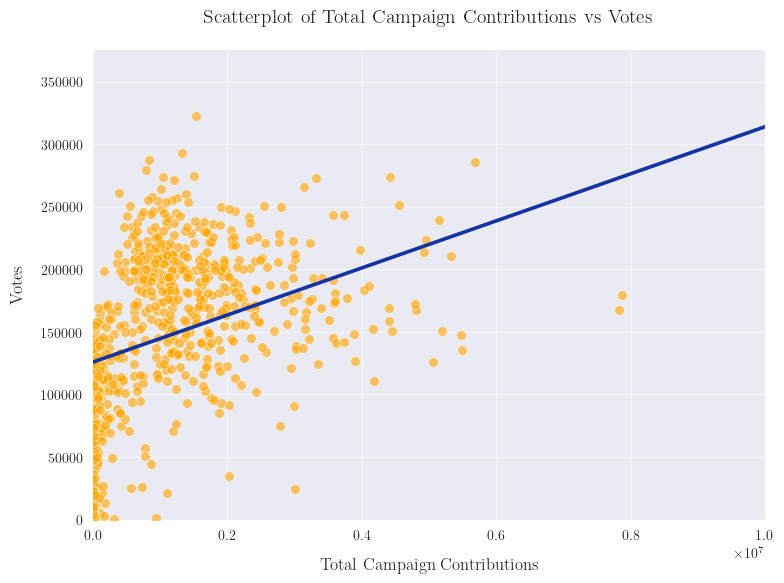

In [5]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=house, x='tot_rec', y='votes', alpha=0.6, color='orange')

sns.regplot(data=house, x='tot_rec', y='votes', scatter=False, line_kws={'color': '#1434A4'}, ci=None)

plt.title("Scatterplot of Total Campaign Contributions vs Votes", fontsize=14, pad=20)
plt.xlabel("Total Campaign Contributions", fontsize=12, labelpad=12)
plt.ylabel("Votes", fontsize=12, labelpad=12)
plt.ylim(0, 375_000)
plt.xlim(0, 10_000_000)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('../../results/smaller-dataset/figures/scatterplot_of_campaign_contributions_vs_votes.png')
plt.show()

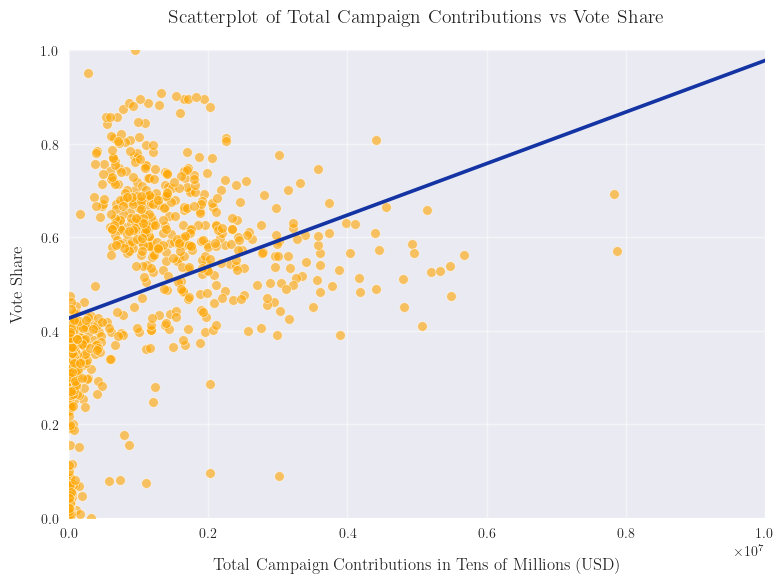

In [6]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=house, x='tot_rec', y='vote_share', alpha=0.6, color='orange')

sns.regplot(data=house, x='tot_rec', y='vote_share', scatter=False, line_kws={'color': '#1434A4'}, ci=None)

plt.title("Scatterplot of Total Campaign Contributions vs Vote Share", fontsize=14, pad=20)
plt.xlabel("Total Campaign Contributions in Tens of Millions (USD)", fontsize=12, labelpad=12)
plt.ylabel("Vote Share", fontsize=12, labelpad=12)
plt.xlim(0, 10_000_000)
plt.ylim(0, 1)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('../../results/smaller-dataset/figures/scatterplot_of_campaign_contributions_vs_vote_share.png')
plt.show()

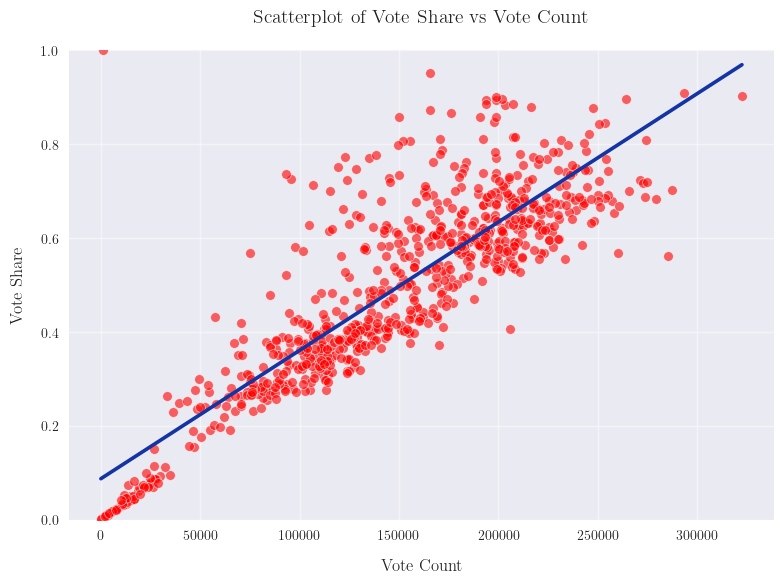

In [7]:
plt.figure(figsize=(8, 6))

sns.scatterplot(data=house, x='votes', y='vote_share', alpha=0.6, color='red')

sns.regplot(data=house, x='votes', y='vote_share', scatter=False, line_kws={'color': '#1434A4'}, ci=None)

plt.title("Scatterplot of Vote Share vs Vote Count", fontsize=14, pad=20)
plt.xlabel("Vote Count", fontsize=12, labelpad=12)
plt.ylabel("Vote Share", fontsize=12, labelpad=12)
plt.ylim(0, 1)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('../../results/smaller-dataset/figures/scatterplot_of_vote_share_vs_vote_count.png')
plt.show()

#### Descriptive Statistics and Histograms for Total Campaign Contributions

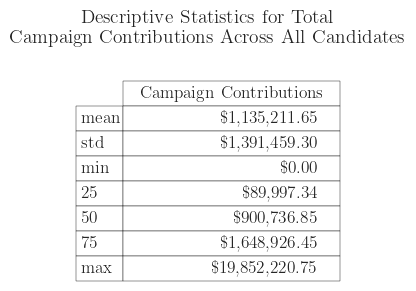

In [8]:
d = house[['tot_rec']].describe().drop(index='count')

d['tot_rec'] = d['tot_rec'].apply(lambda x: f"\${x:,.2f}" if isinstance(x, (int, float)) else x)

d.rename(columns={'tot_rec':'Campaign Contributions'}, inplace=True)

fig, ax = plt.subplots(figsize=(3,3))

ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=d.values,
    colLabels=d.columns,
    rowLabels=d.index,
    loc='center',
    cellLoc='right'
)

table.auto_set_font_size(False)
table.set_fontsize(12.5)
table.scale(1, 2)
fig.suptitle('Descriptive Statistics for Total\n Campaign Contributions Across All Candidates', fontsize=14)
fig.tight_layout()
fig.savefig('../../results/smaller-dataset/tables/table_of_descriptive_statistics_for_total_campaign_receipts_across_all_candidates.png')
plt.show()

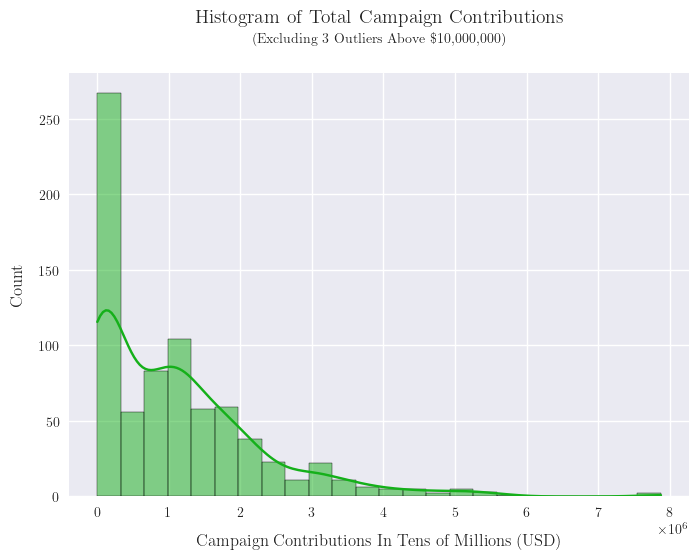

In [9]:
sns.histplot(data=house[house['tot_rec']<10000000], x='tot_rec', kde=True, color='#15b01a') # Exlcude three outliers receiving more than $10,000,000 for legibility

plt.title('Histogram of Total Campaign Contributions\n\\normalsize{(Excluding 3 Outliers Above \$10,000,000)}', fontsize=14, pad=22)
plt.xlabel('Campaign Contributions In Tens of Millions (USD)', labelpad=10, fontsize=12)
plt.ylabel('Count', fontsize=12, labelpad=10)
plt.savefig('../../results/smaller-dataset/figures/histogram_of_total_campaign_receipts.png')
plt.show()

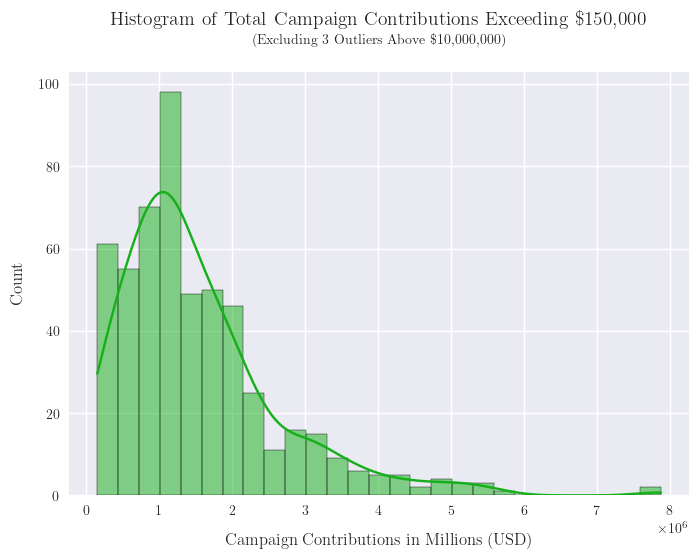

In [10]:
sns.histplot(data=house[house['tot_rec']>150000][house['tot_rec']<10000000], x='tot_rec', kde=True, color='#15b01a') # Exclude candidates receiving less $100,000 and more than $10,000,000

plt.title('Histogram of Total Campaign Contributions Exceeding \$150,000\n\\normalsize{(Excluding 3 Outliers Above \$10,000,000)}', fontsize=14, pad=20)
plt.xlabel('Campaign Contributions in Millions (USD)', labelpad=10, fontsize=12)
plt.ylabel('Count', fontsize=12, labelpad=10)
plt.savefig('../../results/smaller-dataset/figures/histogram_of_total_campaign_receipts_exceeding_150000_usd.png')
plt.show()

#### Total Campaign Contributions by Election Outcome

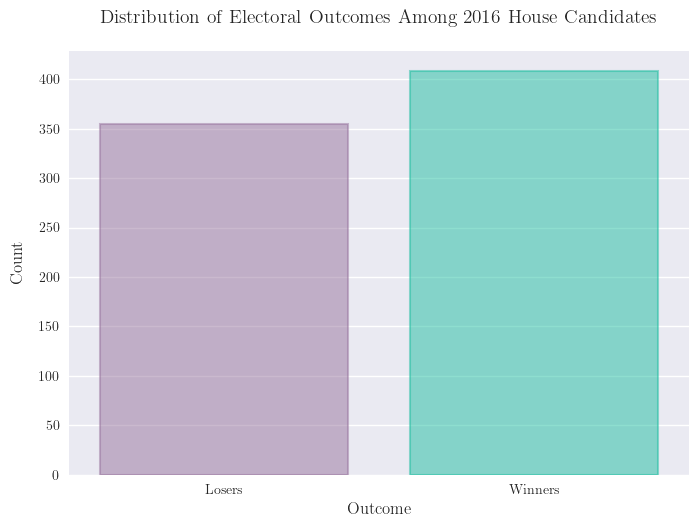

In [11]:
barplot = sns.countplot(data=house, x='winner', palette=['#9c6da5','#04d8b2'], alpha=0.5)

plt.title('Distribution of Electoral Outcomes Among 2016 House Candidates', fontsize=14, pad=20)
bars = plt.gca().patches  
for bar in barplot.patches:
    bar_color = bar.get_facecolor()  
    bar.set_edgecolor(bar_color)   
    bar.set_linewidth(1.5)    
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Count', labelpad=10, fontsize=12)
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.savefig('../../results/smaller-dataset/figures/barplot_of_distribution_of_electoral_outcomes_among_2016_house_candidates.png')
plt.show()

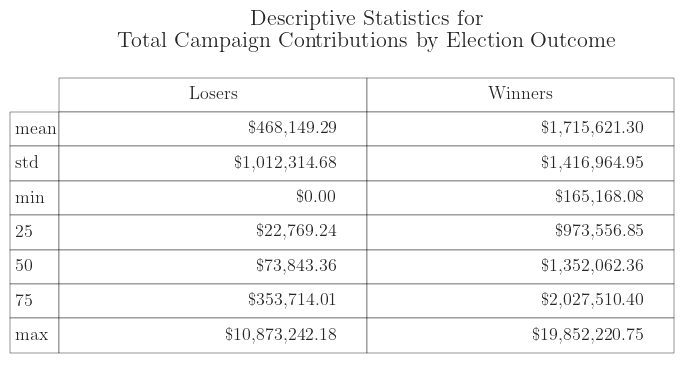

In [12]:
describe_losers = house[house['winner']==0]['tot_rec'].describe().apply(lambda x: f"\${x:,.2f}" 
                                                                        if isinstance(x, (int, float)) else x).drop('count', axis='index')

describe_winners = house[house['winner']==1]['tot_rec'].describe().apply(lambda x: f"\${x:,.2f}" 
                                                                         if isinstance(x, (int, float)) else x).drop('count', axis='index')

des = pd.concat([describe_losers, describe_winners], axis='columns')

fig, ax = plt.subplots(figsize=(7,4))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
for cell in table.get_celld().values():
    cell.set_fontsize(13)    
table.scale(1,2)
plt.title('Descriptive Statistics for\nTotal Campaign Contributions by Election Outcome', fontsize=16)
fig.tight_layout()
fig.savefig('../../results/smaller-dataset/tables/table_of_descriptive_statistics_for_total_campaign_receipts_by_election_outcome.png')
plt.show()

In [13]:
house[house['tot_rec']==np.min(house[house['winner']==1]['tot_rec'])]

,state_abbr,state,district,fec_id,first_name,last_name,name,party,votes,vote_share,winner,inc,tot_rec
174,FL,Florida,10,H2FL08063,val,demings,val demings,Democrat,198491,0.648687,1,Challenger,165168.08


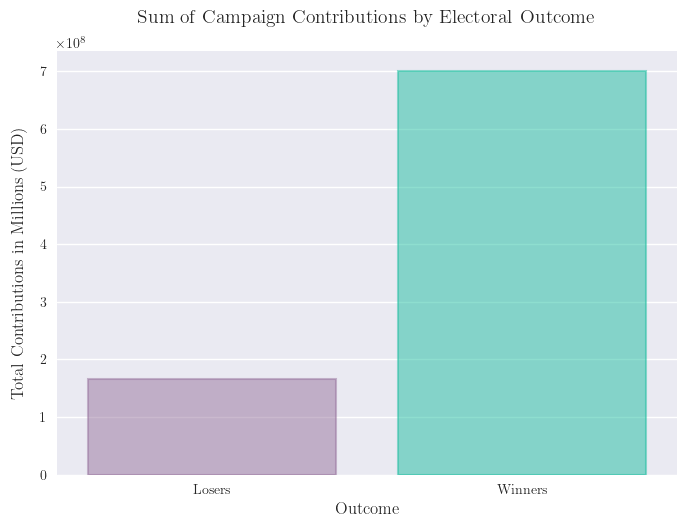

In [14]:
tot_rec_by_outcome = [house[house['winner']==0]['tot_rec'].sum(), house[house['winner']==1]['tot_rec'].sum()]

barplot = sns.barplot(x=[0,1], y=tot_rec_by_outcome, palette=['#9c6da5','#04d8b2'], alpha=0.5)
bars = plt.gca().patches  
for bar in barplot.patches:
    bar_color = bar.get_facecolor()  
    bar.set_edgecolor(bar_color)   
    bar.set_linewidth(1.5)     
plt.title('Sum of Campaign Contributions by Electoral Outcome', fontsize=14, pad=20)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Total Contributions in Millions (USD)', labelpad=10, fontsize=12)
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.savefig('../../results/smaller-dataset/figures/barplot_of_sum_of_campaign_contributions_by_electoral_outcome.png')
plt.show()

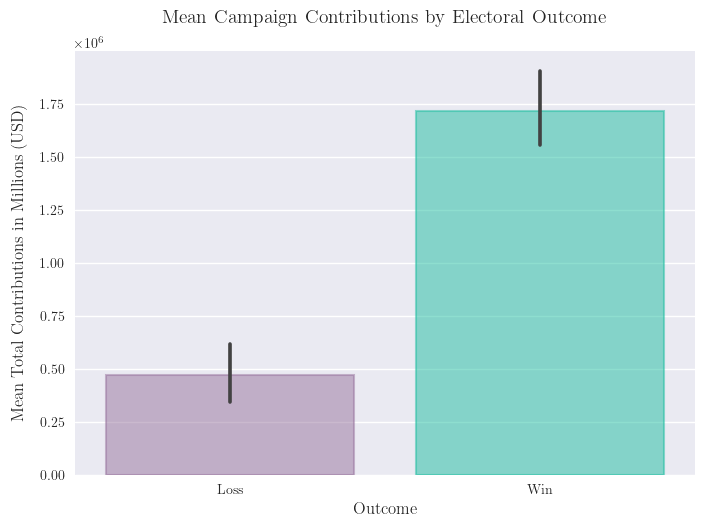

In [15]:
barplot = sns.barplot(data=house, x='winner', y='tot_rec', palette=['#9c6da5','#04d8b2'], errorbar=('ci',99), alpha=0.5)
bars = plt.gca().patches  
for bar in barplot.patches:
    bar_color = bar.get_facecolor()  
    bar.set_edgecolor(bar_color)   
    bar.set_linewidth(1.5)  
plt.title('Mean Campaign Contributions by Electoral Outcome', fontsize=14, pad=20)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Mean Total Contributions in Millions (USD)', labelpad=10, fontsize=12)
plt.xticks(ticks=[0,1], labels=['Loss','Win'])
plt.savefig('../../results/smaller-dataset/figures/barplot_of_mean_campaign_contributions_by_electoral_outcome.png')
plt.show()

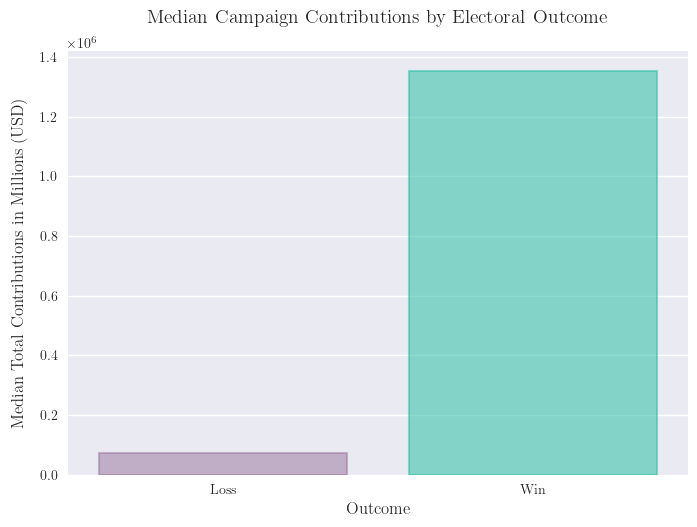

In [16]:
med_rec_by_outcome = [house[house['winner']==0]['tot_rec'].median(), house[house['winner']==1]['tot_rec'].median()]

barplot = sns.barplot(data=pd.DataFrame(med_rec_by_outcome), x=[0,1], y=med_rec_by_outcome, palette=['#9c6da5','#04d8b2'], errorbar=None, alpha=0.5)
bars = plt.gca().patches  
for bar in barplot.patches:
    bar_color = bar.get_facecolor()  
    bar.set_edgecolor(bar_color)   
    bar.set_linewidth(1.5)  
plt.title('Median Campaign Contributions by Electoral Outcome', fontsize=14, pad=20)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Median Total Contributions in Millions (USD)', labelpad=10, fontsize=12)
plt.xticks(ticks=[0,1], labels=['Loss','Win'])
plt.savefig('../../results/smaller-dataset/figures/barplot_of_median_campaign_contributions_by_electoral_outcome.png')
plt.show()

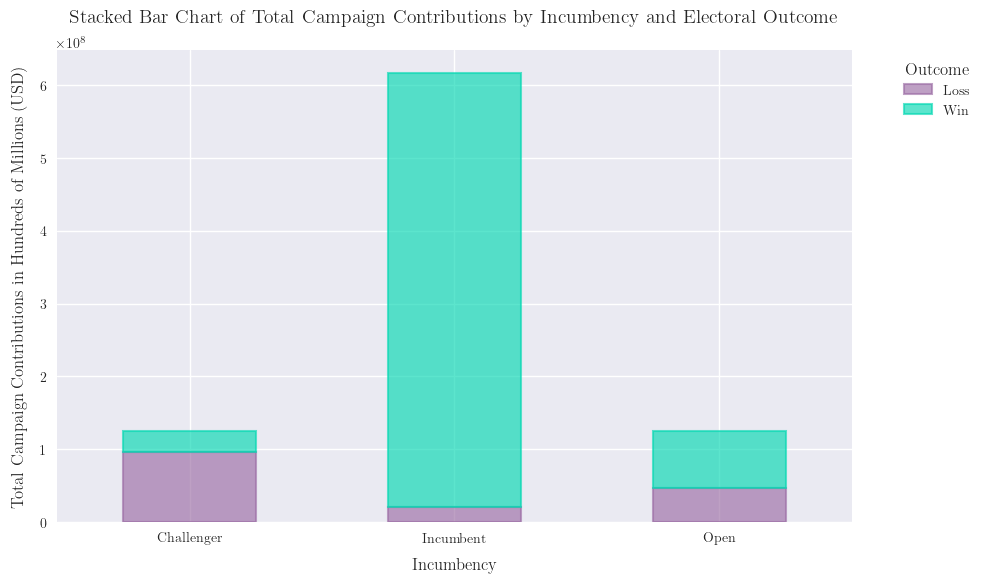

In [17]:
aggregated_data = house.groupby(['inc', 'winner'], as_index=False)['tot_rec'].sum()

pivot_data = aggregated_data.pivot(index='inc', columns='winner', values='tot_rec')

barplot = pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#9c6da5','#04d8b2'], alpha=0.65)
bars = plt.gca().patches  
for bar in barplot.patches:
    bar_color = bar.get_facecolor()  
    bar.set_edgecolor(bar_color)   
    bar.set_linewidth(1.5) 
plt.title('Stacked Bar Chart of Total Campaign Contributions by Incumbency and Electoral Outcome', pad=20, fontsize=14)
plt.xlabel('Incumbency', labelpad=10, fontsize=12)
plt.ylabel('Total Campaign Contributions in Hundreds of Millions (USD)', labelpad=10, fontsize=12)
plt.legend(title='Outcome', labels=['Loss','Win'], bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.xticks(rotation=0) 
plt.tight_layout()  
plt.savefig('../../results/smaller-dataset/figures/stacked_barplot_total_contributions_by_outcome_and_incumbency_restricted.png')
plt.show()

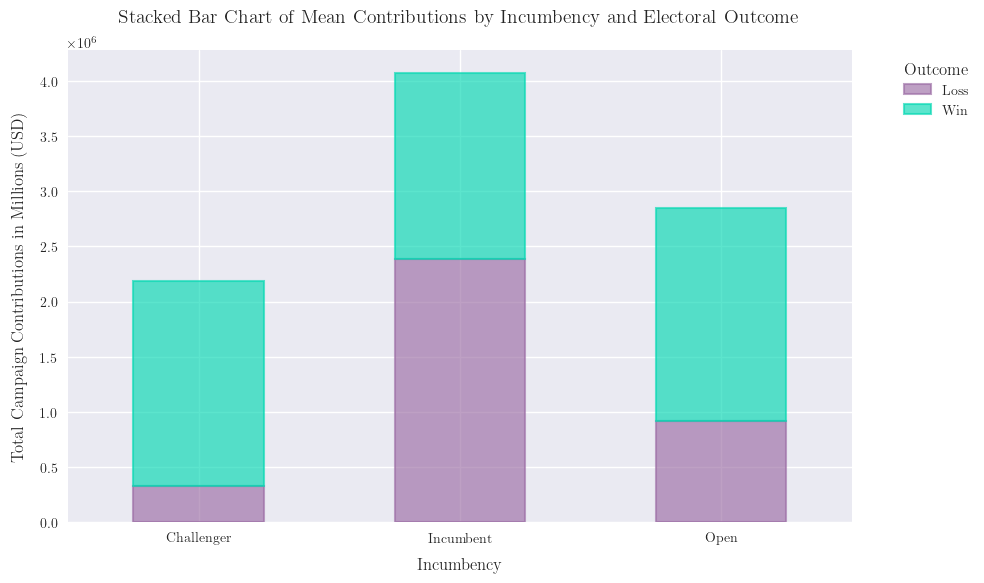

In [18]:
aggregated_data = house.groupby(['inc', 'winner'], as_index=False)['tot_rec'].mean()

pivot_data = aggregated_data.pivot(index='inc', columns='winner', values='tot_rec')

barplot = pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#9c6da5','#04d8b2'], alpha=0.65)
bars = plt.gca().patches  
for bar in barplot.patches:
    bar_color = bar.get_facecolor()  
    bar.set_edgecolor(bar_color)   
    bar.set_linewidth(1.5) 
plt.title('Stacked Bar Chart of Mean Contributions by Incumbency and Electoral Outcome', pad=20, fontsize=14)
plt.xlabel('Incumbency', labelpad=10, fontsize=12)
plt.ylabel('Total Campaign Contributions in Millions (USD)', labelpad=10, fontsize=12)
plt.legend(title='Outcome', labels=['Loss','Win'], bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.xticks(rotation=0) 
plt.tight_layout()  
plt.savefig('../../results/smaller-dataset/figures/stacked_barplot_avg_total_contributions_by_outcome_and_incumbency_restricted.png')
plt.show()

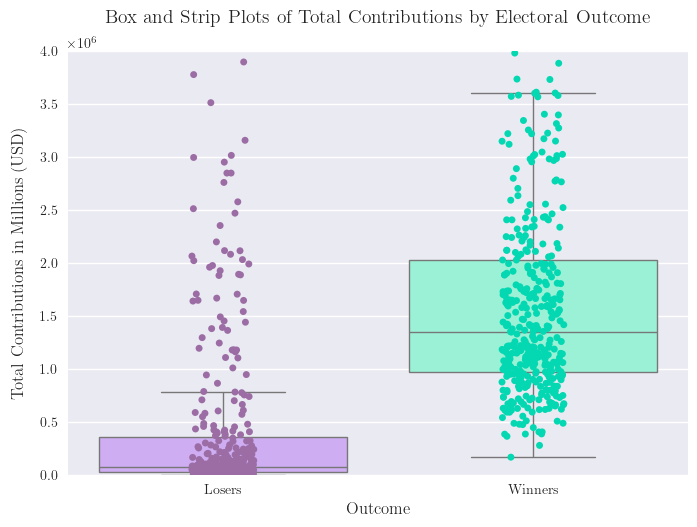

In [19]:
fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000)) 

ax = sns.boxplot(data=house, x='winner', y='tot_rec', showfliers=False, palette=['#cea2fd','#8cffdb'])

ax = sns.stripplot(data=house, x='winner', y='tot_rec', palette=['#9c6da5','#04d8b2'])

plt.title('Box and Strip Plots of Total Contributions by Electoral Outcome', fontsize=14, pad=20)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Total Contributions in Millions (USD)', labelpad=10, fontsize=12)
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.savefig('../../results/smaller-dataset/figures/box_and_strip_plots_of_total_contributions_by_electoral_outcome.png')
plt.show()

#### Focus on the Two Ruling Parties

In [20]:
duopoly = house.query("party in ['Democrat', 'Republican']")

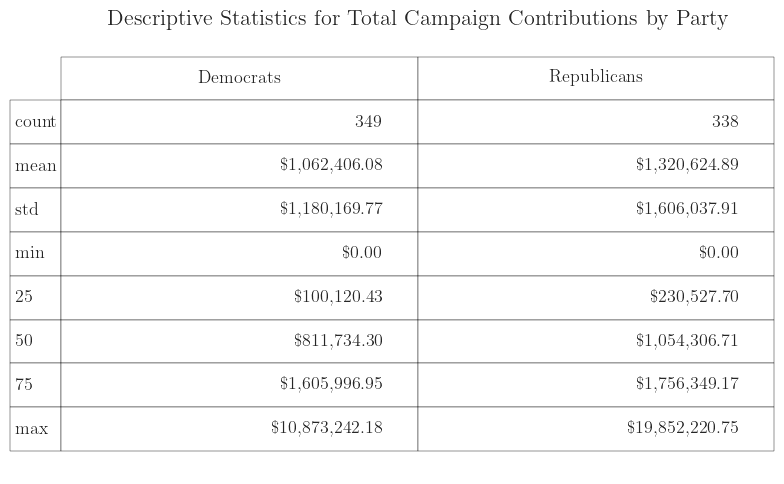

In [21]:
describe_dem = house[house['party']=='Democrat']['tot_rec'].describe().apply(lambda x: f"\${x:,.2f}" if isinstance(x, (int, float)) else x)
describe_dem.loc['count'] = describe_dem.loc['count'].replace('\$','').split('.')[0]

describe_rep = house[house['party']=='Republican']['tot_rec'].describe().apply(lambda x: f"\${x:,.2f}" if isinstance(x, (int, float)) else x)
describe_rep.loc['count'] = describe_rep.loc['count'].replace('\$','').split('.')[0]

des_party = pd.concat([describe_dem, describe_rep], axis='columns')

fig, ax = plt.subplots(figsize=(8, 5))

ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des_party.values.tolist(),rowLabels=des_party.index,colLabels=['Democrats','Republicans'],
                   loc='center')
for cell in table.get_celld().values():
    cell.set_fontsize(13)   
table.scale(1,2.3)
plt.title('Descriptive Statistics for Total Campaign Contributions by Party', fontsize=16)
fig.tight_layout()
fig.savefig('../../results/smaller-dataset/tables/table_of_descriptive_statistics_for_total_received_campaign_funds_by_party.png')
plt.show()

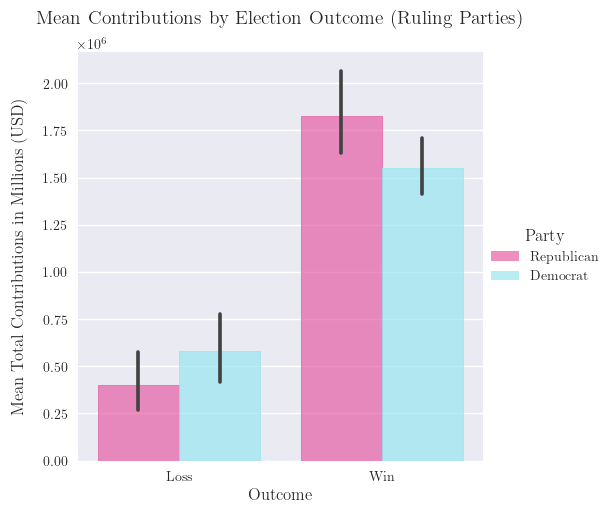

In [22]:
duopoly.rename(columns={'party':'Party'}, inplace=True)

catplot = sns.catplot(data=duopoly, kind='bar', x='winner', y='tot_rec', hue='Party', hue_order=['Republican','Democrat'], palette=['#fe46a5','#8af1fe'], alpha=0.69)
for ax in catplot.axes.flat:
    for bar in ax.patches:  
        bar.set_edgecolor(bar.get_facecolor())  
        bar.set_linewidth(0.75) 
plt.title('Mean Contributions by Election Outcome (Ruling Parties)', fontsize=14, pad=20)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Mean Total Contributions in Millions (USD)', labelpad=12, fontsize=12)
plt.xticks(ticks=[0,1], labels=['Loss','Win'])
plt.savefig('../../results/smaller-dataset/figures/barplot_of_mean_contributions_by_electoral_outcome_ruling_parties.png')
plt.show()

#### Association of Incumbency with Contributions and Outcome

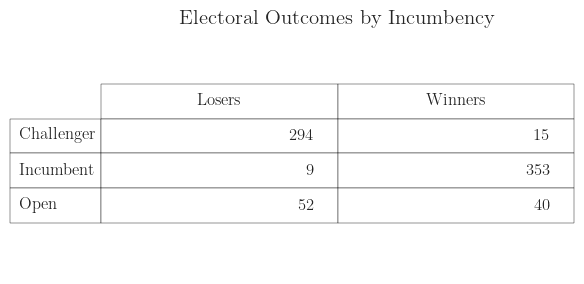

In [23]:
win_by_inc = pd.concat([house[house['winner']==0].groupby('inc')['winner'].count(), 
                       house[house['winner']==1].groupby('inc')['winner'].count()], axis='columns'
)

fig, ax = plt.subplots(figsize=(6, 3))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=win_by_inc.values.tolist(), rowLabels=win_by_inc.index, colLabels=['Losers','Winners'], loc='center')
for cell in table.get_celld().values():
    cell.set_fontsize(12)  
table.scale(1,2)
plt.title('Electoral Outcomes by Incumbency', fontsize=15)
fig.tight_layout()
fig.savefig('../../results/smaller-dataset/tables/table_of_electoral_outcome_by_incumbency.png')
plt.show()

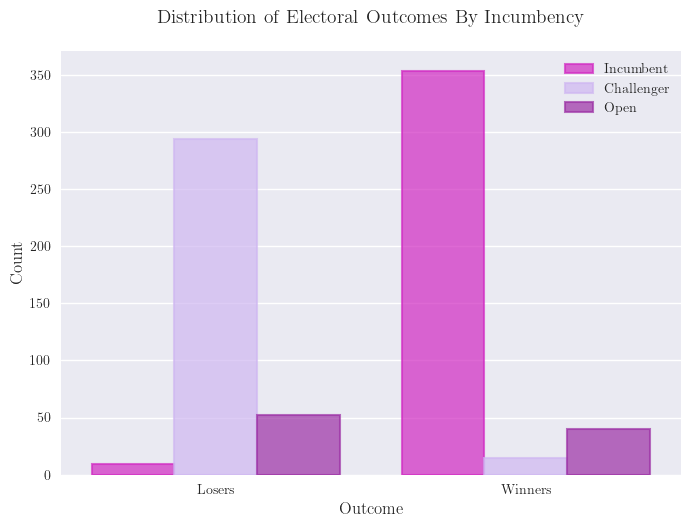

In [24]:
barplot = sns.countplot(data=house, x='winner', hue='inc', hue_order=['Incumbent','Challenger','Open'], palette=['#ed0dd9', '#ceaefa', '#ac1db8'], alpha=0.7)
bars = plt.gca().patches  
for bar in barplot.patches:
    bar_color = bar.get_facecolor()  
    bar.set_edgecolor(bar_color)   
    bar.set_linewidth(1.5)  
plt.title('Distribution of Electoral Outcomes By Incumbency', fontsize=14, pad=20)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.gca().legend().set_title('')
plt.savefig('../../results/smaller-dataset/figures/barplot_of_distribution_of_electoral_outcomes_by_incumbency.png')
plt.show()

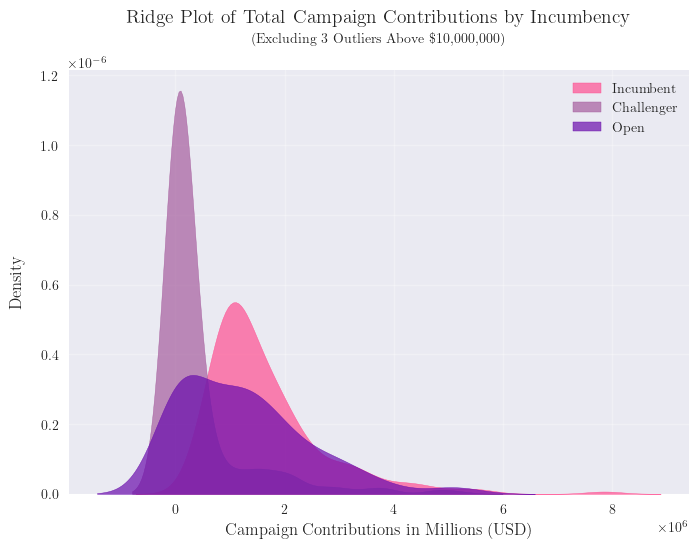

In [25]:
h = house.copy(deep=True)
h = h[h['tot_rec']<10000000]

plt.figure()

for i, level in enumerate(h['inc'].unique()):
    subset = h[h['inc'] == level]    
    sns.kdeplot(data=subset, x='tot_rec', fill=True, alpha=0.7, label=f'{level}', color=['#ff4f91', '#a65e9e', '#6a0dad'][i % 3])
plt.title("Ridge Plot of Total Campaign Contributions by Incumbency\n\\normalsize{(Excluding 3 Outliers Above \$10,000,000)}", pad=20, fontsize=14)
plt.xlabel("Campaign Contributions in Millions (USD)", fontsize=12)
plt.ylabel('Density', fontsize=12, labelpad=12)
plt.legend(title="")
plt.grid(alpha=0.3)
plt.savefig('../../results/smaller-dataset/figures/ridgeplot_of_total_contributions_by_incumbency.png')
plt.show()

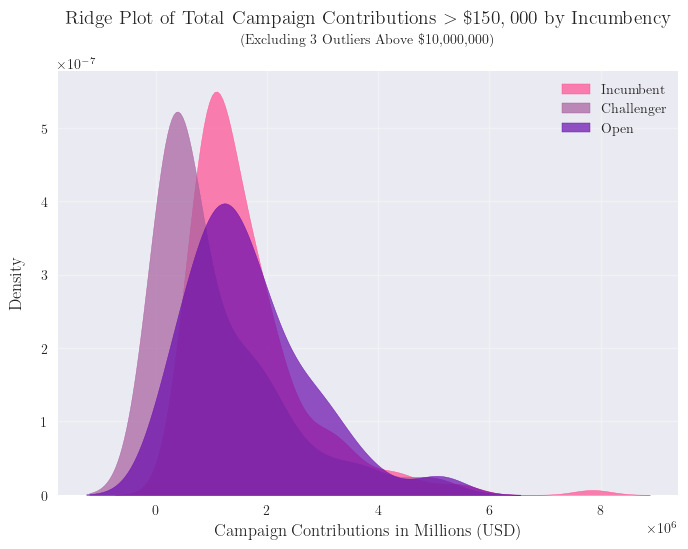

In [26]:
h = house.copy(deep=True)
h = h[h['tot_rec']<10000000][h['tot_rec']>150000]

plt.figure()

for i, level in enumerate(h['inc'].unique()):
    subset = h[h['inc'] == level]    
    sns.kdeplot(data=subset, x='tot_rec', fill=True, alpha=0.7, label=f'{level}', color=['#ff4f91', '#a65e9e', '#6a0dad'][i % 3])
plt.title("Ridge Plot of Total Campaign Contributions $>\$150,000$ by Incumbency\n\\normalsize{(Excluding 3 Outliers Above \$10,000,000)}", pad=20, fontsize=14)
plt.xlabel("Campaign Contributions in Millions (USD)", fontsize=12)
plt.ylabel('Density', fontsize=12, labelpad=12)
plt.legend(title="")
plt.grid(alpha=0.3)
plt.savefig('../../results/smaller-dataset/figures/ridgeplot_of_total_contributions_by_incumbency_restricted.png')
plt.show()

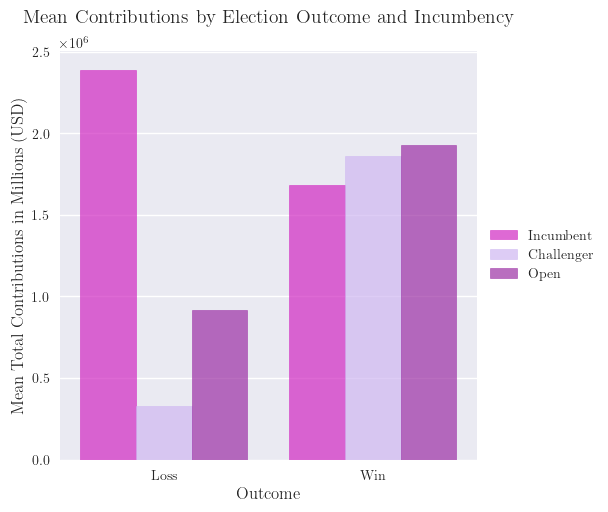

In [27]:
catplot = sns.catplot(data=house, kind='bar', x='winner', y='tot_rec', hue='inc', errorbar=None, hue_order=['Incumbent','Challenger','Open'],
            palette=['#ed0dd9', '#ceaefa', '#ac1db8'], legend=False, alpha=0.7)
for ax in catplot.axes.flat:
    for bar in ax.patches:  
        bar.set_edgecolor(bar.get_facecolor())  
        bar.set_linewidth(0.5)   
plt.title('Mean Contributions by Election Outcome and Incumbency', fontsize=14, pad=20)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Mean Total Contributions in Millions (USD)', fontsize=12)
plt.xticks(ticks=[0,1], labels=['Loss','Win'])
plt.legend(title='', labels=['Incumbent','Challenger','Open'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('../../results/smaller-dataset/figures/barplot_of_mean_contributions_by_electoral_outcome_and_incumbency.png')
plt.show()

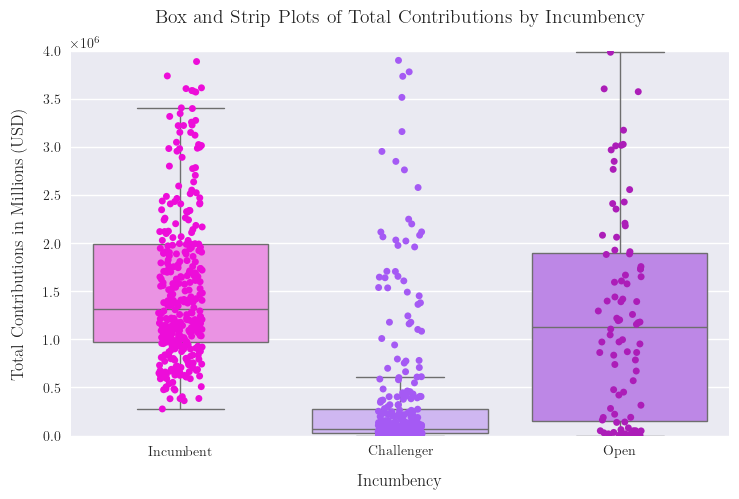

In [28]:
fig, ax = plt.subplots(figsize=(8.5,5))

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house, x='inc', y='tot_rec', showfliers=False, palette=['#f984ef', '#ceaefa', '#bf77f6'])

ax = sns.stripplot(data=house, x='inc', y='tot_rec', palette=['#ed0dd9', '#a55af4', '#ac1db8'])

plt.title('Box and Strip Plots of Total Contributions by Incumbency', fontsize=14, pad=20)
plt.xlabel('Incumbency', fontsize=12, labelpad=12)
plt.ylabel('Total Contributions in Millions (USD)', fontsize=12, labelpad=12)
plt.xticks(ticks=[0,1,2], labels=['Incumbent','Challenger','Open'])
plt.savefig('../../results/smaller-dataset/figures/box_and_strip_plots_of_total_contributions_by_incumbency.png')
plt.show()

#### Incumbents

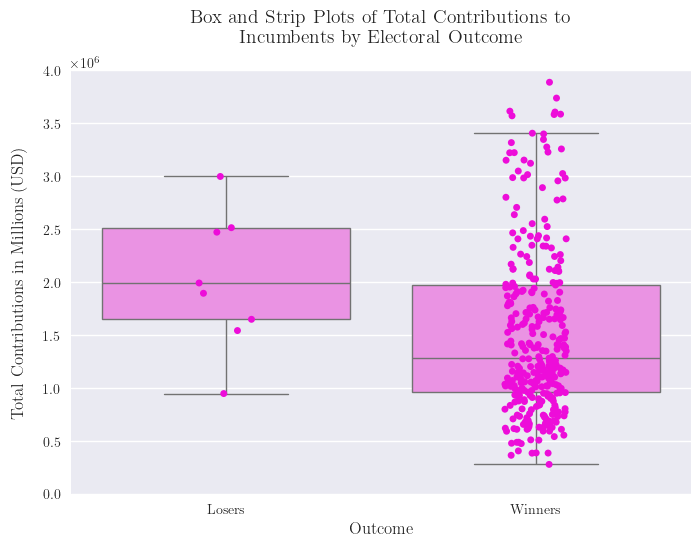

In [29]:
fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Incumbent'], x='winner', y='tot_rec', showfliers=False, palette=['#f984ef'])

ax = sns.stripplot(data=house[house['inc']=='Incumbent'], x='winner', y='tot_rec', palette=['#ed0dd9'])

plt.title('Box and Strip Plots of Total Contributions to\nIncumbents by Electoral Outcome', fontsize=14, pad=20)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Total Contributions in Millions (USD)', fontsize=12, labelpad=12)
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.savefig('../../results/smaller-dataset/figures/box_and_strip_plots_of_total_contributions_by_electoral_outcome_incumbents.png')
plt.show()

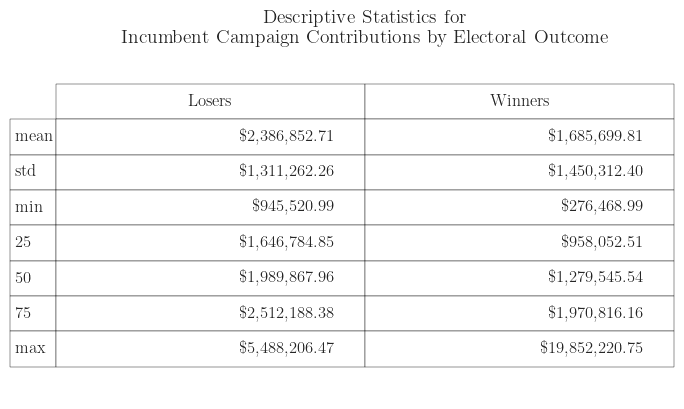

In [30]:
incumbent = house[house['inc']=='Incumbent']

describe_losers = incumbent[incumbent['winner']==0]['tot_rec'].describe().apply(lambda x: f'\${x:,.2f}' if isinstance(x, (int, float)) else x).drop('count', axis='index')

describe_winners = incumbent[incumbent['winner']==1]['tot_rec'].describe().apply(lambda x: f"\${x:,.2f}" if isinstance(x, (int, float)) else x).drop('count', axis='index')

des = pd.concat([describe_losers, describe_winners], axis='columns')

fig, ax = plt.subplots(figsize=(7,4.25))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
table.scale(1,2)
plt.title('Descriptive Statistics for\nIncumbent Campaign Contributions by Electoral Outcome       ', fontsize=14)
fig.tight_layout()
plt.savefig('../../results/smaller-dataset/tables/table_of_descriptive_statistics_for_total_campaign_receipts_by_electoral_outcome_incumbents.png')
plt.show()

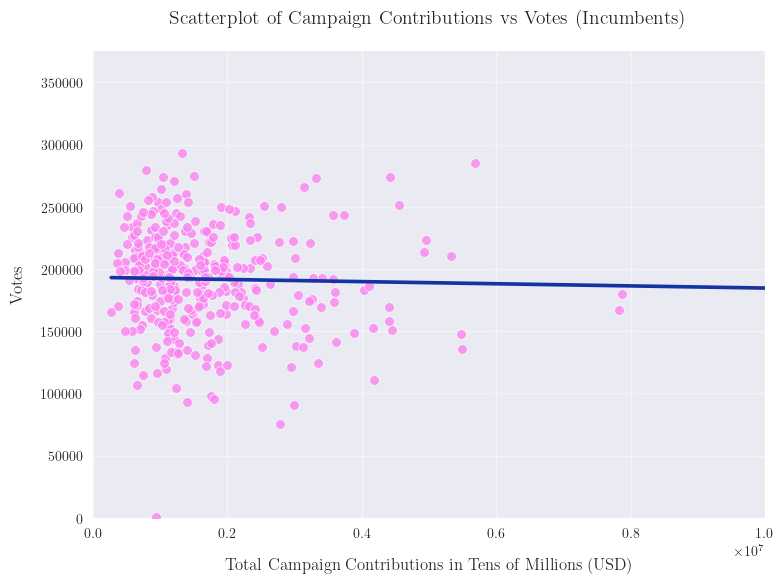

In [31]:
plt.figure(figsize=(8, 6))

sns.scatterplot(data=incumbent, x='tot_rec', y='votes', alpha=0.8, color='#f984ef')

sns.regplot(data=incumbent, x='tot_rec', y='votes', scatter=False, line_kws={'color': '#1434A4'}, ci=None)

plt.title("Scatterplot of Campaign Contributions vs Votes (Incumbents)", fontsize=14, pad=20)
plt.xlabel("Total Campaign Contributions in Tens of Millions (USD)", fontsize=12, labelpad=12)
plt.ylabel("Votes", fontsize=12, labelpad=12)
plt.ylim(0, 375_000)
plt.xlim(0, 10_000_000)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('../../results/smaller-dataset/figures/scatterplot_of_total_contributions_vs_votes_incumbents.png')
plt.show()

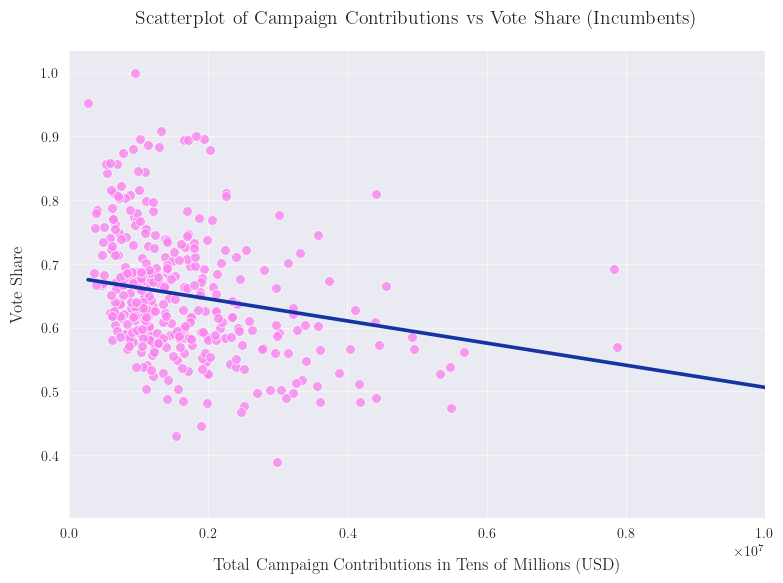

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=incumbent, x='tot_rec', y='vote_share', alpha=0.8, color='#f984ef')

sns.regplot(data=incumbent, x='tot_rec', y='vote_share', scatter=False, line_kws={'color': '#1434A4'}, ci=None)

plt.title("Scatterplot of Campaign Contributions vs Vote Share (Incumbents)", fontsize=14, pad=20)
plt.xlabel("Total Campaign Contributions in Tens of Millions (USD)", fontsize=12, labelpad=12)
plt.ylabel("Vote Share", fontsize=12, labelpad=12)
plt.xlim(0, 10_000_000)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('../../results/smaller-dataset/figures/scatterplot_of_total_contributions_vs_vote_share_incumbents.png')
plt.show()

#### Challengers

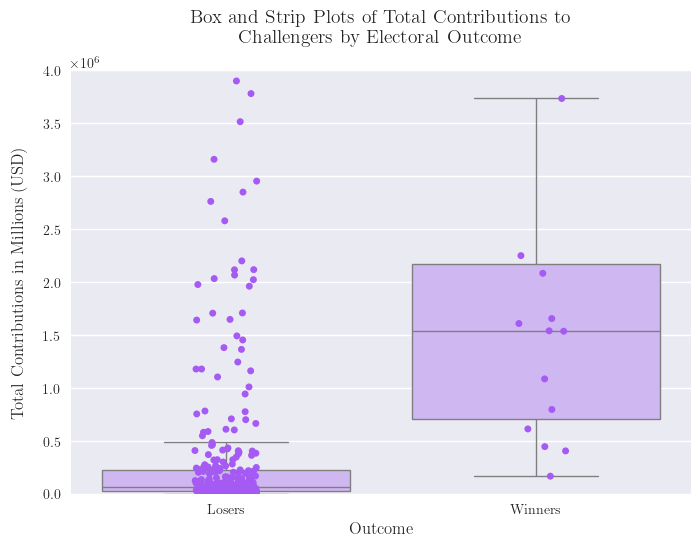

In [33]:
fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Challenger'], x='winner', y='tot_rec', showfliers=False, palette=['#ceaefa'])

ax = sns.stripplot(data=house[house['inc']=='Challenger'], x='winner', y='tot_rec', palette=['#a55af4'])

plt.title('Box and Strip Plots of Total Contributions to\nChallengers by Electoral Outcome', fontsize=14, pad=20)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Total Contributions in Millions (USD)', fontsize=12, labelpad=12)
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.savefig('../../results/smaller-dataset/figures/box_and_strip_plots_of_total_contributions_by_electoral_outcome_challengers.png')
plt.show()

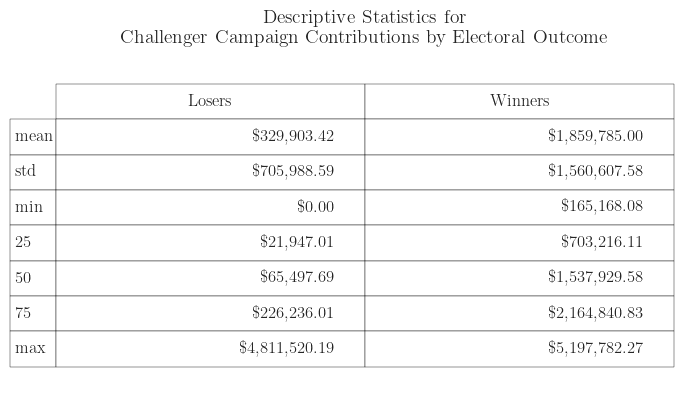

In [34]:
challenger = house[house['inc']=='Challenger']

describe_losers = challenger[challenger['winner']==0]['tot_rec'].describe().apply(lambda x: f'\${x:,.2f}' if isinstance(x, (int, float)) else x).drop('count', axis='index')

describe_winners = challenger[challenger['winner']==1]['tot_rec'].describe().apply(lambda x: f"\${x:,.2f}" if isinstance(x, (int, float)) else x).drop('count', axis='index')

des = pd.concat([describe_losers, describe_winners], axis='columns')

fig, ax = plt.subplots(figsize=(7,4.25))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
table.scale(1,2)
plt.title('Descriptive Statistics for\nChallenger Campaign Contributions by Electoral Outcome       ', fontsize=14)
fig.tight_layout()
plt.savefig('../../results/smaller-dataset/tables/table_of_descriptive_statistics_for_total_campaign_receipts_by_electoral_outcome_challenger.png')
plt.show()

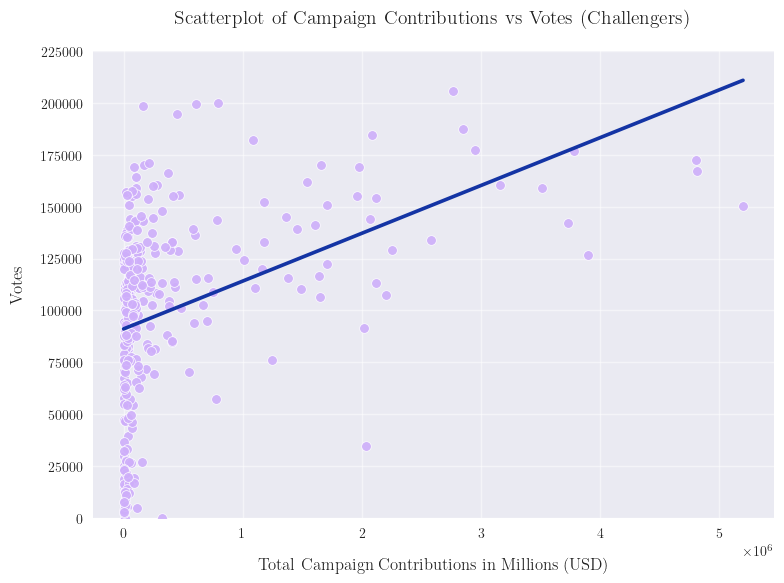

In [35]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=challenger, x='tot_rec', y='votes', alpha=0.9, color='#ceaefa')

sns.regplot(data=challenger, x='tot_rec', y='votes', scatter=False, line_kws={'color': '#1434A4'}, ci=None)

plt.title("Scatterplot of Campaign Contributions vs Votes (Challengers)", fontsize=14, pad=20)
plt.xlabel("Total Campaign Contributions in Millions (USD)", fontsize=12, labelpad=12)
plt.ylabel("Votes", fontsize=12, labelpad=12)
plt.ylim(0, 225_000)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('../../results/smaller-dataset/figures/scatterplot_of_total_contributions_vs_votes_challengers.png')
plt.show()

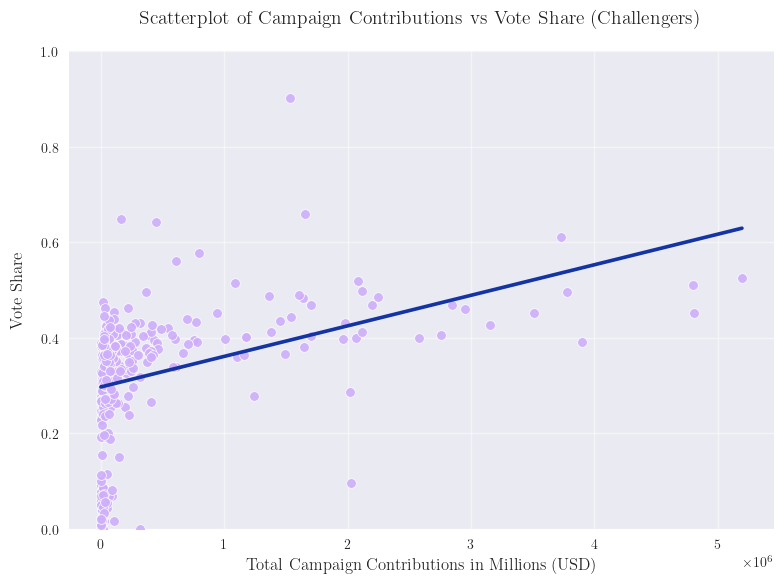

In [36]:
plt.figure(figsize=(8, 6))

sns.scatterplot(data=challenger, x='tot_rec', y='vote_share', alpha=0.9, color='#ceaefa')

sns.regplot(data=challenger, x='tot_rec', y='vote_share', scatter=False, line_kws={'color': '#1434A4'}, ci=None)

plt.title("Scatterplot of Campaign Contributions vs Vote Share (Challengers)", fontsize=14, pad=20)
plt.xlabel("Total Campaign Contributions in Millions (USD)", fontsize=12)
plt.ylabel("Vote Share", fontsize=12, labelpad=12)
plt.ylim(0, 1)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('../../results/smaller-dataset/figures/scatterplot_of_total_contributions_vs_vote_share_challengers.png')
plt.show()

#### Open Seat Contenders

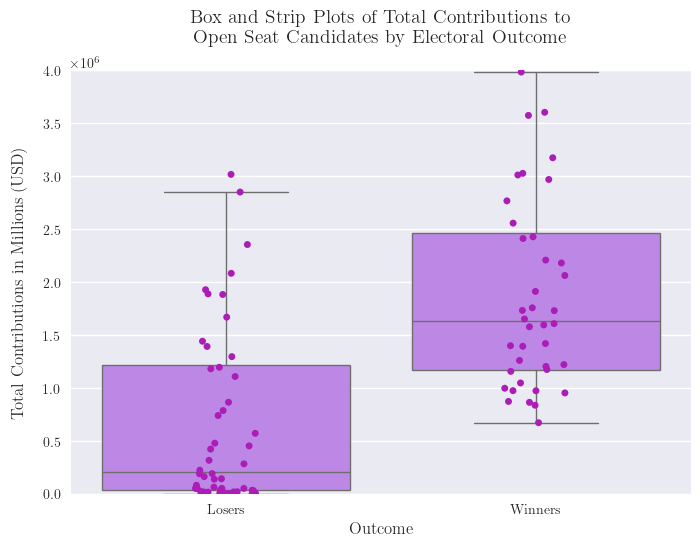

In [37]:
fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Open'], x='winner', y='tot_rec', showfliers=False, palette=['#bf77f6'])

ax = sns.stripplot(data=house[house['inc']=='Open'], x='winner', y='tot_rec', palette=['#ac1db8'])

plt.title('Box and Strip Plots of Total Contributions to\nOpen Seat Candidates by Electoral Outcome', pad=20, fontsize=14)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Total Contributions in Millions (USD)', fontsize=12, labelpad=12)
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.savefig('../../results/smaller-dataset/figures/box_and_strip_plots_of_total_contributions_by_electoral_outcome_open_contenders.png')
plt.show()

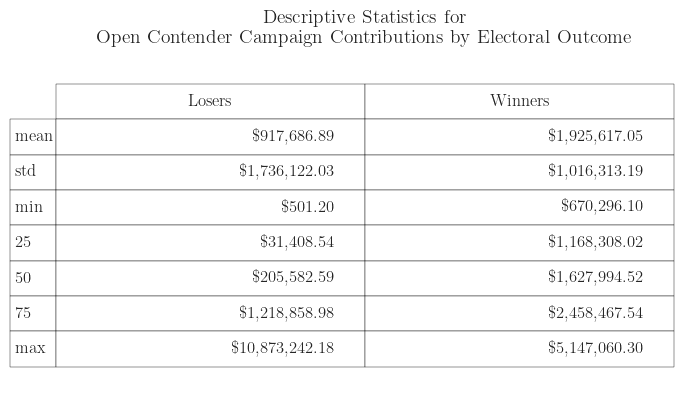

In [38]:
open_ = house[house['inc']=='Open']

describe_losers = open_[open_['winner']==0]['tot_rec'].describe().apply(lambda x: f'\${x:,.2f}' if isinstance(x, (int, float)) else x).drop('count', axis='index')

describe_winners = open_[open_['winner']==1]['tot_rec'].describe().apply(lambda x: f"\${x:,.2f}" if isinstance(x, (int, float)) else x).drop('count', axis='index')

des = pd.concat([describe_losers, describe_winners], axis='columns')

fig, ax = plt.subplots(figsize=(7,4.25))

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
table.scale(1,2)
plt.title('Descriptive Statistics for\nOpen Contender Campaign Contributions by Electoral Outcome       ', fontsize=14)
fig.tight_layout()
plt.savefig('../../results/smaller-dataset/tables/table_of_descriptive_statistics_for_total_campaign_receipts_by_electoral_outcome_open_contenders.png')
plt.show()

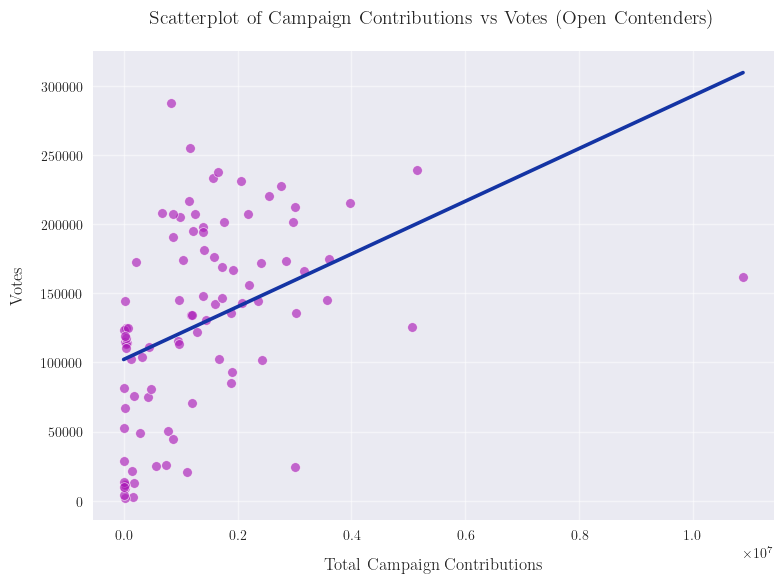

In [39]:
plt.figure(figsize=(8, 6))

sns.scatterplot(data=open_, x='tot_rec', y='votes', alpha=0.65, color='#ac1db8')

sns.regplot(data=open_, x='tot_rec', y='votes', scatter=False, line_kws={'color': '#1434A4'}, ci=None)

plt.title("Scatterplot of Campaign Contributions vs Votes (Open Contenders)", fontsize=14, pad=20)
plt.xlabel("Total Campaign Contributions", fontsize=12, labelpad=12)
plt.ylabel("Votes", fontsize=12, labelpad=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('../../results/smaller-dataset/figures/scatterplot_of_total_contributions_vs_votes_open_contenders.png')
plt.show()

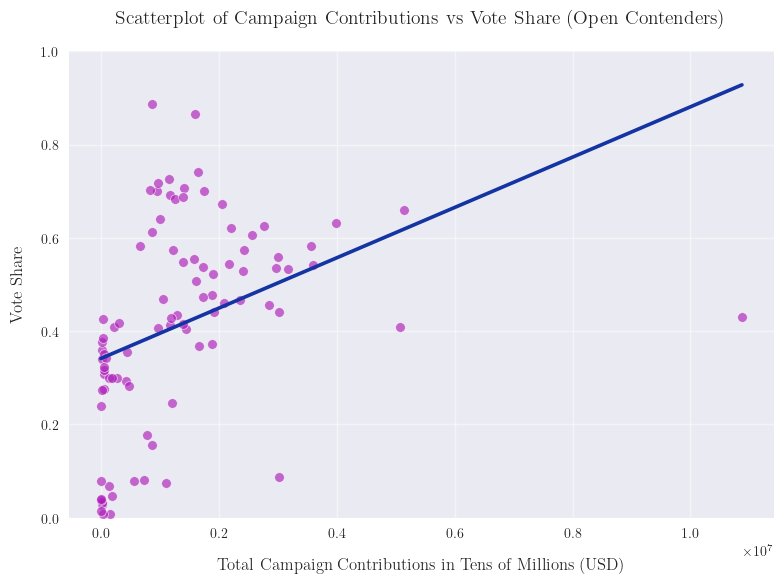

In [40]:
plt.figure(figsize=(8, 6))

sns.scatterplot(data=open_, x='tot_rec', y='vote_share', alpha=0.65, color='#ac1db8')

sns.regplot(data=open_, x='tot_rec', y='vote_share', scatter=False, line_kws={'color': '#1434A4'}, ci=None)

plt.title("Scatterplot of Campaign Contributions vs Vote Share (Open Contenders)", fontsize=14, pad=20)
plt.xlabel("Total Campaign Contributions in Tens of Millions (USD)", fontsize=12, labelpad=12)
plt.ylabel("Vote Share", fontsize=12, labelpad=12)
plt.ylim(0, 1)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('../../results/smaller-dataset/figures/scatterplot_of_total_contributions_vs_vote_share_open_contenders.png')
plt.show()

### Analysis

In [41]:
lose_rec = house[house['winner']==0]['tot_rec']

win_rec = house[house['winner']==1]['tot_rec']

#### Check for Normality

The Q-Q plot and normality tests of total campaign contributions below reflect the extreme right skew evidenced by the tables and histograms produced in the [preceding section](#Data-Description-and-Visualization), indicating significant deviation of total campaign contributions $C$ from normality.

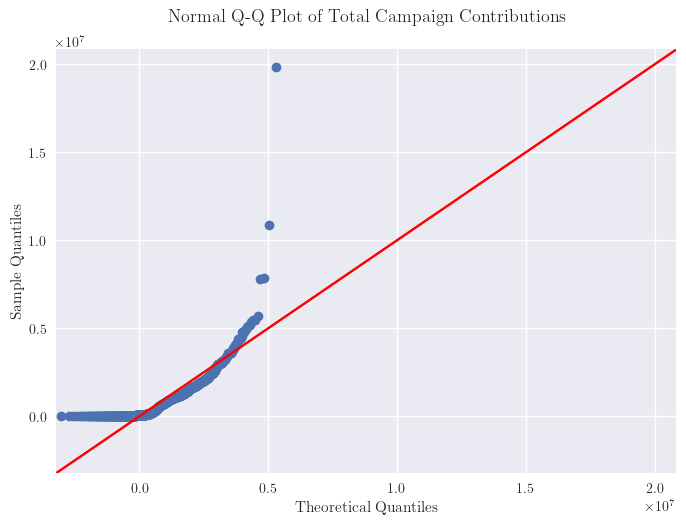

In [42]:
pp = sm.ProbPlot(house['tot_rec'], loc=np.mean(house['tot_rec']), scale=np.std(house['tot_rec']))

ax = pp.qqplot(line='45')

plt.title('Normal Q-Q Plot of Total Campaign Contributions', fontsize=13, pad=20)
plt.show()

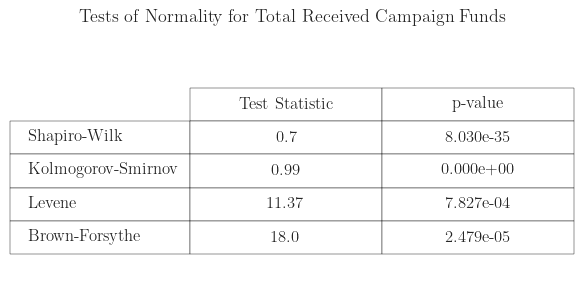

In [43]:
shapiro_wilk = list(map(str, list(stats.shapiro(house['tot_rec']))))
kolmogorov_smirnov = list(map(str, list(stats.kstest(house['tot_rec'], 'norm'))))
levene = list(map(str, list(stats.levene(lose_rec, win_rec, center='mean'))))
brown_forsythe = list(map(str, list(stats.levene(lose_rec, win_rec, center='median'))))

tests = [shapiro_wilk, kolmogorov_smirnov, levene, brown_forsythe] 

test_names = ['Shapiro-Wilk','Kolmogorov-Smirnov', 'Levene','Brown-Forsythe']

test_df = pd.DataFrame(data=tests, index=test_names, columns=['Test Statistic', 'p-value']).astype(float)

test_df['Test Statistic'] = test_df['Test Statistic'].round(2)

test_df['p-value'] = test_df['p-value'].apply(lambda x: f"{x:.3e}")

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')
plt.rcParams['font.family'] = 'Verdana'

table = ax.table(
    cellText=test_df.values,
    colLabels=test_df.columns,
    rowLabels=test_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
fig.suptitle('Tests of Normality for Total Received Campaign Funds', fontsize=13)
fig.tight_layout()
plt.savefig('../../results/smaller-dataset/tables/table_of_normality_tests.png')
plt.show()

### Correlation Analysis and Non-Parametric Comparison Testing

As a supplement to the displays and associated remarks in the [Data Description and Visulization](#Data-Description-and-Visualization) section, a series of correlation coefficients and comparison tests are produced below.

#### Correlations

Unsurprisingly, the correlation between campaign contributions and election outcome passes the threshold of statistical significance, with each of the following three computed coefficient values (all of which exceed $0.5$) indicating a strong relationship.

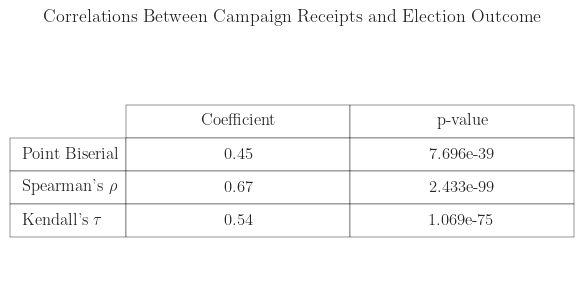

In [44]:
pearson = list(map(str, list(stats.pearsonr(house['tot_rec'],house['winner']))))
spearman = list(map(str, list(stats.spearmanr(house['tot_rec'],house['winner']))))
kendall = list(map(str, list(stats.kendalltau(house['tot_rec'],house['winner']))))

coeffs = [pearson, spearman, kendall]

coeff_names = ["Point Biserial", "Spearman's $\\rho$", "Kendall's $\\tau$"]

coeff_df = pd.DataFrame(data=coeffs, index=coeff_names, columns=['Coefficient', 'p-value']).astype(float)

coeff_df['Coefficient'] = coeff_df['Coefficient'].round(2)

coeff_df['p-value'] = coeff_df['p-value'].apply(lambda x: f"{x:.3e}")

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')
plt.rcParams['font.family'] = 'Verdana'

table = ax.table(
    cellText=coeff_df.values,
    colLabels=coeff_df.columns,
    rowLabels=coeff_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
fig.suptitle('Correlations Between Campaign Receipts and Election Outcome', fontsize=13)
fig.tight_layout()
plt.savefig('../../results/smaller-dataset/tables/table_of_correlation_coefficients.png')
plt.show()

#### Comparison Tests

As can be seen by inspection of the following table, the difference in total campaign contributions between electoral winners and losers achieves statistical significance.

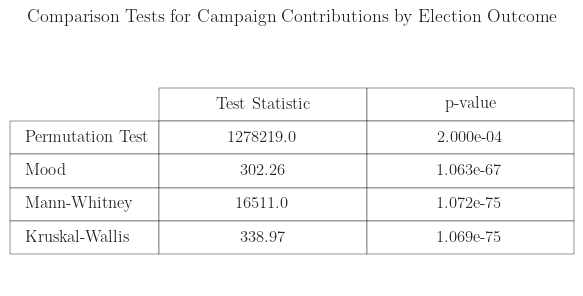

In [45]:
def test_statistic(x, y, axis):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

pt = stats.permutation_test([win_rec, lose_rec], test_statistic)

perm = [pt.statistic, pt.pvalue]
mood = list(map(str, list(stats.median_test(lose_rec, win_rec))))[0:2]
mann_whitney = list(map(str, list(stats.mannwhitneyu(lose_rec, win_rec))))       
kruskal_wallis = list(map(str, list(stats.kruskal(lose_rec,win_rec))))

tests = [perm, mood, mann_whitney, kruskal_wallis]

test_names = ['Permutation Test', 'Mood', 'Mann-Whitney','Kruskal-Wallis']

test_df = pd.DataFrame(data=tests, index=test_names, columns=['Test Statistic', 'p-value']).astype(float)

test_df['Test Statistic'] = test_df['Test Statistic'].round(2)

test_df['p-value'] = test_df['p-value'].apply(lambda x: f"{x:.3e}")

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')
plt.rcParams['font.family'] = 'Verdana'

table = ax.table(
    cellText=test_df.values,
    colLabels=test_df.columns,
    rowLabels=test_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.scale(1, 2)
fig.suptitle('Comparison Tests for Campaign Contributions by Election Outcome', fontsize=13)
fig.tight_layout()
plt.savefig('../../results/smaller-dataset/tables/table_of_comparison_tests.png')
plt.show()

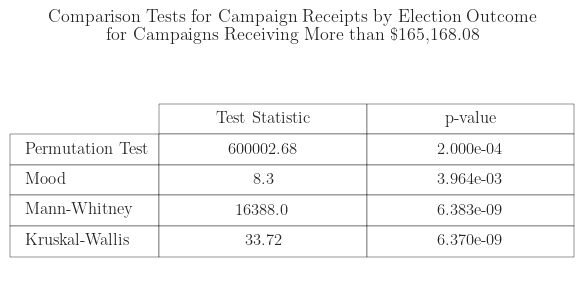

In [46]:
win_rec = win_rec[win_rec>165168.08]
lose_rec = lose_rec[lose_rec>165168.08]

def test_statistic(x, y, axis):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

pt = stats.permutation_test([win_rec, lose_rec], test_statistic)

perm = [pt.statistic, pt.pvalue]
mood = list(map(str, list(stats.median_test(lose_rec, win_rec))))[0:2]
mann_whitney = list(map(str, list(stats.mannwhitneyu(lose_rec, win_rec))))    
kruskal_wallis = list(map(str, list(stats.kruskal(lose_rec,win_rec))))

tests = [perm, mood, mann_whitney, kruskal_wallis]

test_names = ['Permutation Test', 'Mood', 'Mann-Whitney','Kruskal-Wallis']

test_df = pd.DataFrame(data=tests, index=test_names, columns=['Test Statistic', 'p-value']).astype(float)

test_df['Test Statistic'] = test_df['Test Statistic'].round(2)

test_df['p-value'] = test_df['p-value'].apply(lambda x: f"{x:.3e}")

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')
plt.rcParams['font.family'] = 'Verdana'

table = ax.table(
    cellText=test_df.values,
    colLabels=test_df.columns,
    rowLabels=test_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.scale(1, 2)
fig.suptitle('Comparison Tests for Campaign Receipts by Election Outcome\nfor Campaigns Receiving More than \$165,168.08', fontsize=13)
fig.tight_layout()
plt.savefig('../../results/smaller-dataset/tables/table_of_comparison_tests.png')
plt.show()

### Sample Proportions and Tests of Independence

#### Proportion of Wins by Incumbency

In [47]:
h_inc = house[house['inc']=='Incumbent']
h_chal = house[house['inc']=='Challenger']
h_open = house[house['inc']=='Open']

p_inc = round(np.shape(h_inc[h_inc['winner']==1])[0] / np.shape(h_inc)[0], 3)
p_chal = round(np.shape(h_chal[h_chal['winner']==1])[0] / np.shape(h_chal)[0], 3)
p_open = round(np.shape(h_open[h_open['winner']==1])[0] / np.shape(h_open)[0], 3)

print('Proportion of incumbents who won:', p_inc)
print('Proportion of challengers who won:', p_chal)
print('Proportion of open contenders who won:', p_open)

Proportion of incumbents who won: 0.975
Proportion of challengers who won: 0.049
Proportion of open contenders who won: 0.435


#### Proportion of Wins by Incumbency Among Winners

In [48]:

h_inc = house[house['inc']=='Incumbent']
h_chal = house[house['inc']=='Challenger']
h_open = house[house['inc']=='Open']

p_inc = round(np.shape(h_inc[h_inc['winner']==1])[0] / np.shape(house[house['winner']==1])[0], 3)
p_chal = round(np.shape(h_chal[h_chal['winner']==1])[0] / np.shape(house[house['winner']==1])[0], 3)
p_open = round(np.shape(h_open[h_open['winner']==1])[0] / np.shape(house[house['winner']==1])[0], 3)

print('Proportion of incumbents among winners:', p_inc)
print('Proportion of challengers among winners:', p_chal)
print('Proportion of open contenders among winners:', p_open)

Proportion of incumbents among winners: 0.865
Proportion of challengers among winners: 0.037
Proportion of open contenders among winners: 0.098


#### 𝛘² Test of Idependence

Although strong dependence between electoral victory $W$ and incumbency $I$ is readily apparent from inspection of the displays in the preceding section, in the interest of completeness, a 𝛘² test of independence is carried out below.

In [49]:
observed = pd.crosstab(index=house['inc'], columns=house['winner'])

display(observed)

winner,0,1
inc,,
Challenger,294,15
Incumbent,9,353
Open,52,40


In [50]:
expected = pd.DataFrame(stats.chi2_contingency(observed).expected_freq, index=['Challenger','Incumbent','Open'],
             columns=['Loss','Win']).round().astype(int)

display(expected)

,Loss,Win
Challenger,144,165
Incumbent,168,194
Open,43,49


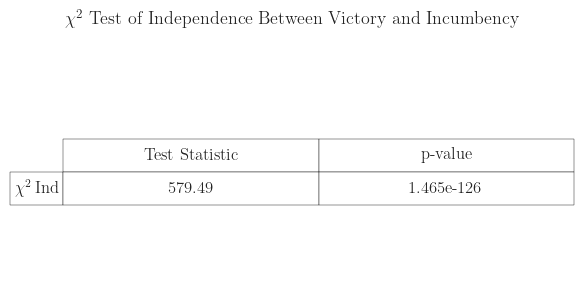

In [51]:
chi2 = list(map(str, [stats.chi2_contingency(observed).statistic, stats.chi2_contingency(observed).pvalue]))

tests = [chi2]

test_names = ["$\\chi^2\\:\\rm{Ind}$"]

test_df = pd.DataFrame(data=tests, index=test_names, columns=['Test Statistic', 'p-value']).astype(float)

test_df['Test Statistic'] = test_df['Test Statistic'].round(2)

test_df['p-value'] = test_df['p-value'].apply(lambda x: f"{x:.3e}")

test_df = pd.DataFrame(data=tests, index=test_names, columns=['Test Statistic', 'p-value']).astype(float)

test_df['Test Statistic'] = test_df['Test Statistic'].round(2)

test_df['p-value'] = test_df['p-value'].apply(lambda x: f"{x:.3e}")

fig, ax = plt.subplots(figsize=(6, 3))

ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=test_df.values,
    colLabels=test_df.columns,
    rowLabels=test_df.index,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
fig.suptitle('$\\chi^2$ Test of Independence Between Victory and Incumbency', fontsize=13)
fig.tight_layout()
plt.savefig('../../results/smaller-dataset/tables/table_chi2_test.png')
plt.show()

### Linear Regression Analysis

#### Ordinary Linear Regression

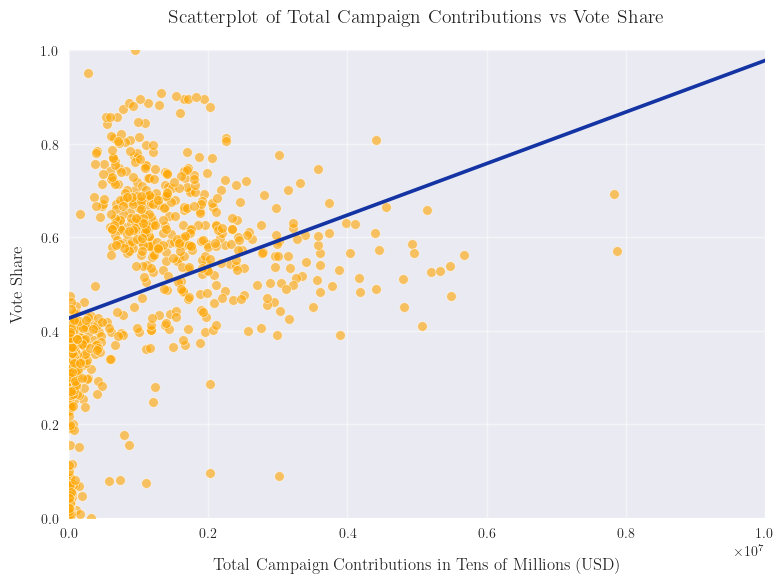

In [52]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=house, x='tot_rec', y='vote_share', alpha=0.6, color='orange')

sns.regplot(data=house, x='tot_rec', y='vote_share', scatter=False, line_kws={'color': '#1434A4'}, ci=None)

plt.title("Scatterplot of Total Campaign Contributions vs Vote Share", fontsize=14, pad=20)
plt.xlabel("Total Campaign Contributions in Tens of Millions (USD)", fontsize=12, labelpad=12)
plt.ylabel("Vote Share", fontsize=12, labelpad=12)
plt.xlim(0, 10_000_000)
plt.ylim(0, 1)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [53]:
X = house['tot_rec'].copy(deep=True)
X = sm.add_constant(X)
y = house['vote_share'].copy(deep=True)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     125.4
Date:                Wed, 15 Jan 2025   Prob (F-statistic):           4.81e-27
Time:                        18:11:58   Log-Likelihood:                 188.94
No. Observations:                 763   AIC:                            -373.9
Df Residuals:                     761   BIC:                            -364.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4267      0.009     48.275      0.0

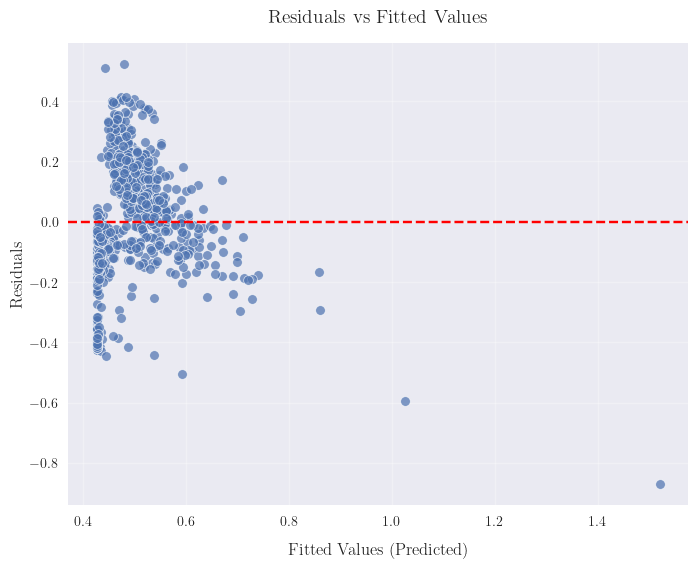

In [54]:
y_pred = model.predict(X)
residuals = y - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values", fontsize=14, pad=15)
plt.xlabel("Fitted Values (Predicted)", fontsize=12, labelpad=10)
plt.ylabel("Residuals", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

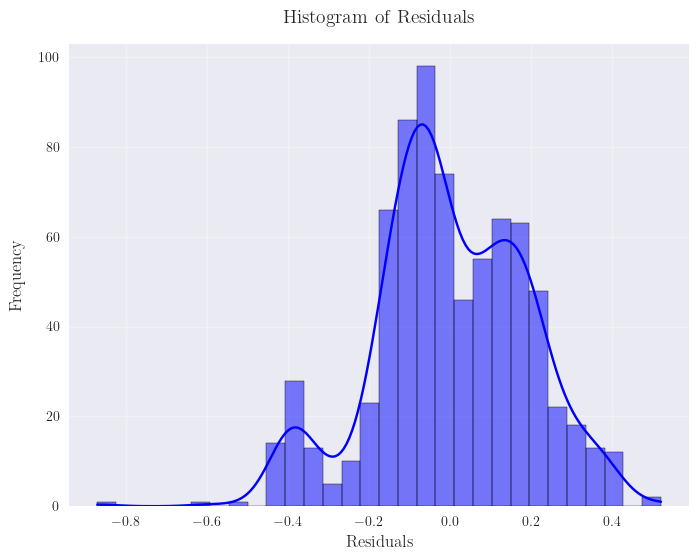

In [55]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Histogram of Residuals", fontsize=14, pad=15)
plt.xlabel("Residuals", fontsize=12, labelpad=5)
plt.ylabel("Frequency", fontsize=12, labelpad=10)
plt.grid(alpha=0.3)
plt.show()

#### OLS on Log-Transformed Data

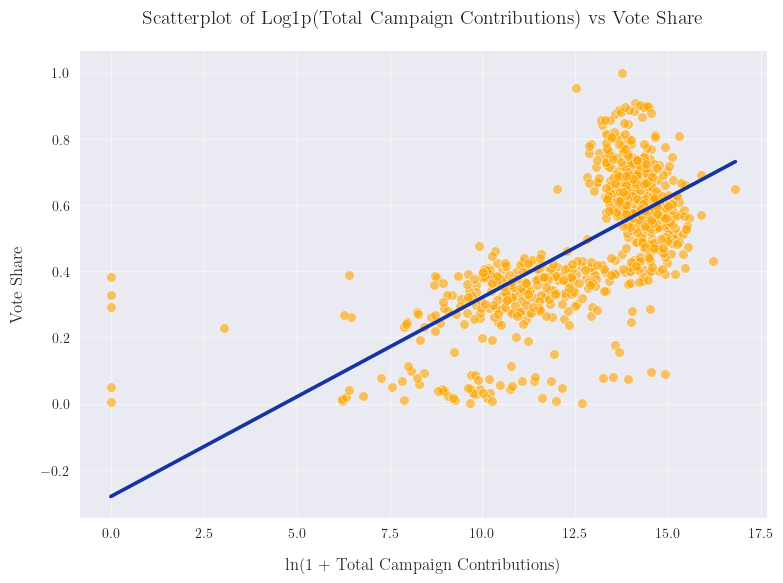

In [56]:
h = house.copy(deep=True)
h['tot_rec'] = np.log1p(h['tot_rec'])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=h, x='tot_rec', y='vote_share', alpha=0.6, color='orange')

sns.regplot(data=h, x='tot_rec', y='vote_share', scatter=False, line_kws={'color': '#1434A4'}, ci=None)

plt.title("Scatterplot of Log1p(Total Campaign Contributions) vs Vote Share", fontsize=14, pad=20)
plt.xlabel("ln(1 + Total Campaign Contributions)", fontsize=12, labelpad=12)
plt.ylabel("Vote Share", fontsize=12, labelpad=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [57]:
X = h['tot_rec']
X = sm.add_constant(X)
y = h['vote_share']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     606.2
Date:                Wed, 15 Jan 2025   Prob (F-statistic):           6.66e-99
Time:                        18:11:58   Log-Likelihood:                 354.26
No. Observations:                 763   AIC:                            -704.5
Df Residuals:                     761   BIC:                            -695.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2808      0.032     -8.842      0.0

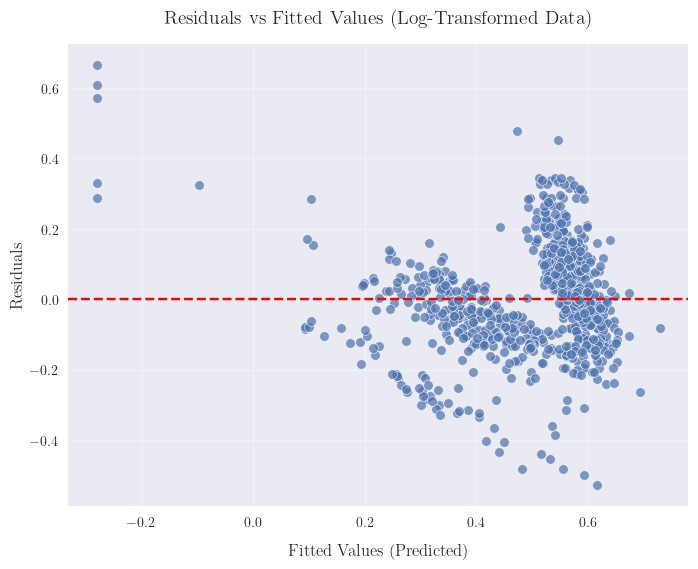

In [58]:
y_pred = model.predict(X)
residuals = y - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values (Log-Transformed Data)", fontsize=14, pad=15)
plt.xlabel("Fitted Values (Predicted)", fontsize=12, labelpad=10)
plt.ylabel("Residuals", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

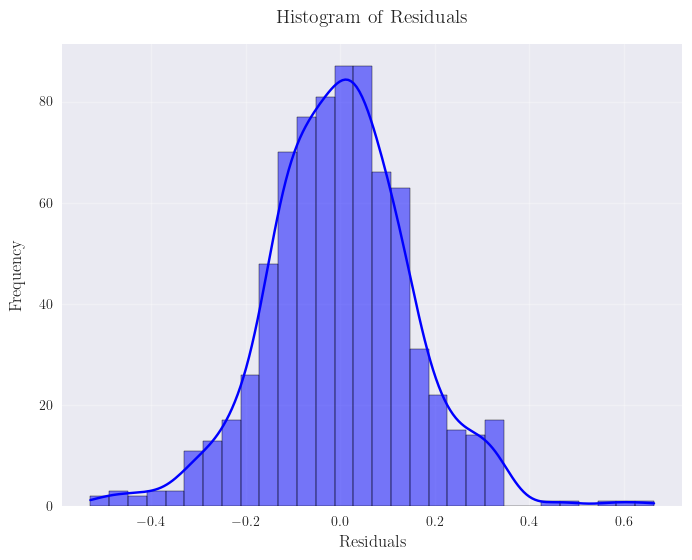

In [59]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Histogram of Residuals", fontsize=14, pad=15)
plt.xlabel("Residuals", fontsize=12, labelpad=5)
plt.ylabel("Frequency", fontsize=12, labelpad=10)
plt.grid(alpha=0.3)
plt.show()

#### Multiple Linear Regression

In [60]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import statsmodels.api as sm

inc_map = {'Open':0,'Challenger':1, 'Incumbent':2}

X = house[['tot_rec', 'inc']].copy(deep=True)  
X['inc'] = X['inc'].map(inc_map)  
X = sm.add_constant(X)  
y = house['vote_share']

model = sm.OLS(y, X).fit()

tot_rec_range = np.linspace(X['tot_rec'].min(), X['tot_rec'].max(), 100)
inc_range = np.linspace(X['inc'].min(), X['inc'].max(), 100)
tot_rec_grid, inc_grid = np.meshgrid(tot_rec_range, inc_range)

X_new = pd.DataFrame({'const': 1, 'tot_rec': tot_rec_grid.ravel(), 'inc': inc_grid.ravel()})
vote_share_pred = model.predict(X_new).values.reshape(tot_rec_grid.shape)

scatter_data = pd.DataFrame({'tot_rec': X['tot_rec'], 'inc': X['inc'], 'vote_share': y})

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=scatter_data['tot_rec'],
    y=scatter_data['inc'],
    z=scatter_data['vote_share'],
    mode='markers',
    marker=dict(size=5, color=scatter_data['vote_share'], colorscale='Viridis'),
    name='Data Points'
))

fig.add_trace(go.Surface(x=tot_rec_range, y=inc_range, z=vote_share_pred, colorscale='Viridis', opacity=0.7, name='Regression Plane'))

fig.update_layout(
    title="Interactive 3D Scatterplot with Regression Plane",
    scene=dict(
        xaxis_title='Campaign Contributions',
        yaxis_title='Incumbency',
        zaxis_title='Vote Share',
        xaxis=dict(range=[0, 10000000]), # Exclude 3 outliers above $10,000,000 for legibility
        zaxis=dict(range=[0,1.05])
    ),
    margin=dict(l=20, r=20, t=40, b=20),
    width=800,
    height=600
)

fig.show()


In [61]:
X = house[['tot_rec', 'inc']].copy(deep=True)
X['inc'] = X['inc'].map(inc_map)
X = sm.add_constant(X)
y = house['vote_share'].copy(deep=True)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     281.4
Date:                Wed, 15 Jan 2025   Prob (F-statistic):           3.41e-92
Time:                        18:11:59   Log-Likelihood:                 342.20
No. Observations:                 763   AIC:                            -678.4
Df Residuals:                     760   BIC:                            -664.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2282      0.013     18.193      0.0

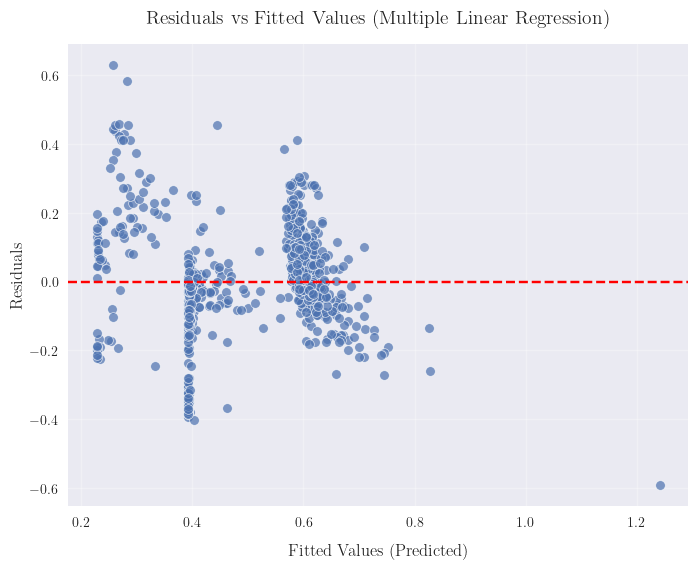

In [62]:
y_pred = model.predict(X)
residuals = y - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values (Multiple Linear Regression)", fontsize=14, pad=15)
plt.xlabel("Fitted Values (Predicted)", fontsize=12, labelpad=10)
plt.ylabel("Residuals", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

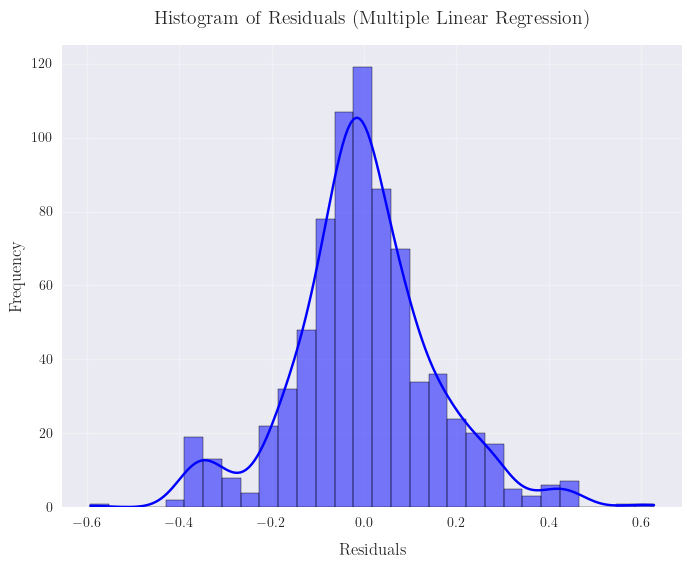

In [63]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Histogram of Residuals (Multiple Linear Regression)", fontsize=14, pad=15)
plt.xlabel("Residuals", fontsize=12, labelpad=10)
plt.ylabel("Frequency", fontsize=12, labelpad=5)
plt.grid(alpha=0.3)
plt.show()

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = house[['tot_rec','inc']].copy(deep=True)
X['inc'] = X['inc'].map(inc_map)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  Variable       VIF
0  tot_rec  1.744834
1      inc  1.744834


### One-Way ANCOVA

In [65]:
h = house.copy(deep=True)

h['inc'] = h['inc'].map(inc_map)

pg.ancova(data=h, dv='vote_share', covar='tot_rec', between='inc')

,Source,SS,DF,F,p-unc,np2
0,inc,14.087763,2,406.956045,7.987576e-121,0.517456
1,tot_rec,0.124957,1,7.219309,7.370165e-03,0.009422
2,Residual,13.137306,759,NaN,NaN,NaN


In [66]:
h = house[house['inc']!='Incumbent'].copy(deep=True)

h['inc'] = h['inc'].map(inc_map)

pg.ancova(data=h, dv='vote_share', covar='tot_rec', between='inc')

,Source,SS,DF,F,p-unc,np2
0,inc,0.077631,1,3.709135,5.482744e-02,0.009233
1,tot_rec,1.494267,1,71.394584,5.564944e-16,0.152099
2,Residual,8.330018,398,NaN,NaN,NaN


### Covariate-Adjusted Logistic Regression Analysis

We now wish to determine the size of the effect of campaign funds in determining electoral outcomes while controlling for the confounding variable of incumbency. As the categorical dependent variable of electoral victory or loss $W$ is not amenable to such an analysis by means of, e.g., one-way ANCOVA, we make use of the Generalized Linear Model (GLM) with logit link

$$\text{logit}(P[W=1]) = \beta_0 + \beta_1 C + \beta_2 I$$

where the dichotomous response variable $W$ denotes electoral victory or loss; the continous explanatory variable $C$ denotes total campaign contributions; and the categorical covariate $I$ denotes incumbency, with $\beta_k$ for $k\in\{0,1,2\}$ denoting the affine model parameters. 

In [67]:
inc_map = {'Open':0,'Challenger':1, 'Incumbent':2}

print('Winner count of untrimmed data:', np.shape(house[house['winner']==1])[0])
print('Loser count of untrimmed data:', np.shape(house[house['winner']==0])[0])
print('Incumbency counts:\n', house['inc'].value_counts().reindex(['Incumbent', 'Challenger', 'Open'], fill_value=0).rename_axis('') )
print()

X = house[['tot_rec', 'inc']].copy(deep=True)
X['inc'] = X['inc'].map(inc_map)
X['intercept'] = 1

y = house['winner'].copy(deep=True)

model = sm.Logit(y, X) 
result = model.fit(cov_type='HC3')

print(result.summary())
print()

marginal_effects = result.get_margeff()
print(marginal_effects.summary())

Winner count of untrimmed data: 408
Loser count of untrimmed data: 355
Incumbency counts:
 
Incumbent     362
Challenger    309
Open           92
Name: count, dtype: int64

Optimization terminated successfully.
         Current function value: 0.349953
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                  763
Model:                          Logit   Df Residuals:                      760
Method:                           MLE   Df Model:                            2
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.4934
Time:                        18:11:59   Log-Likelihood:                -267.01
converged:                       True   LL-Null:                       -527.03
Covariance Type:                  HC3   LLR p-value:                1.194e-113
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------

Area under the ROC curve: 0.907


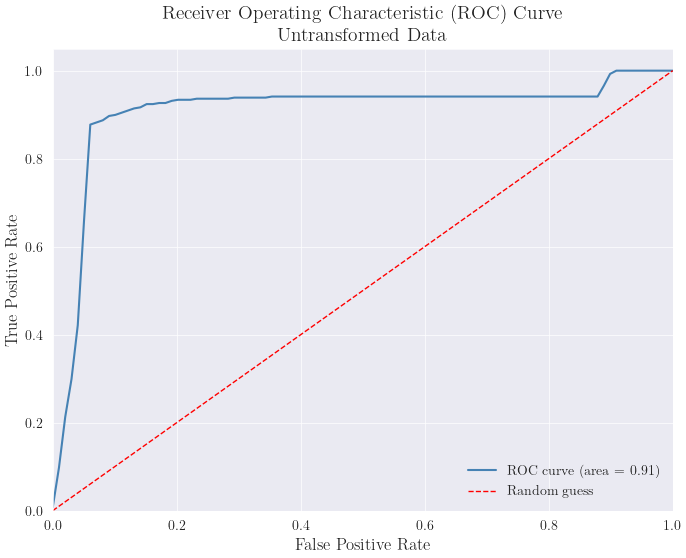

In [68]:
from scipy.interpolate import interp1d

fpr, tpr, thresholds = roc_curve(y, result.predict(X))
roc_auc = auc(fpr, tpr)
print(f'Area under the ROC curve: {roc_auc.round(3)}')

fpr_interp = np.linspace(0, 1, 100)
tpr_interp = interp1d(fpr, tpr, kind='linear')(fpr_interp)

with plt.style.context(['science']):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_interp, tpr_interp, label='ROC curve (area = {:.2f})'.format(roc_auc), color='#4682B4', linewidth=1.5)
    plt.plot([0, 1], [0, 1], label='Random guess', color='red', linestyle='--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.tick_params(axis='both', which='both', length=0)
    plt.title('Receiver Operating Characteristic (ROC) Curve\nUntransformed Data', fontsize=14)
    plt.legend(loc='lower right')
    plt.savefig('../../results/smaller-dataset/figures/roc_plot_logistic_regression_untransformed_data.png')
    plt.show()

In [69]:
import plotly.express as px
import plotly.graph_objects as go

h = house.copy(deep=True)
h['inc'] = h['inc'].map(inc_map)

X = h[['tot_rec', 'inc']]
X = sm.add_constant(X)
y = h['winner']
logit_model = sm.Logit(y, X).fit()

tot_rec_range = np.linspace(0, 10000000, 100)  # Limit tot_rec to exclude 3 outliers above $10,000,000 for legibility
inc_range = np.linspace(h['inc'].min(), h['inc'].max(), 100)
tot_rec_grid, inc_grid = np.meshgrid(tot_rec_range, inc_range)

X_new = pd.DataFrame({'const': 1, 'tot_rec': tot_rec_grid.ravel(), 'inc': inc_grid.ravel()})
y_pred = logit_model.predict(X_new).values.reshape(tot_rec_grid.shape)

plot_data = h[h['tot_rec'] <= 10000000]  # Exclude rows where tot_rec exceeds 10 million

fig = px.scatter_3d(plot_data, x='tot_rec', y='inc', z='winner', opacity=0.5, color='winner', 
                    labels={'tot_rec': 'Contributions', 'inc': 'Incumbency','winner': 'Probability of Victory'},
                    title="Interactive 3D Logistic Regression Plot")

fig.add_trace(go.Surface(x=tot_rec_range, y=inc_range, z=y_pred, opacity=0.7, colorscale='Viridis', showscale=False))

fig.update_layout(
    scene=dict(
        xaxis_title="Contributions",
        yaxis_title="Incumbency",
        zaxis_title="Probability of Victory",
        zaxis=dict(range=[0, 1]),
        xaxis=dict(range=[0, 10000000])  # Restrict tot_rec range for display
    ),
    width=800,
    height=600
)

fig.show()

Optimization terminated successfully.
         Current function value: 0.349953
         Iterations 7


#### Variance Inflation Factor (Untransformed Data)

In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = house[['tot_rec','inc']].copy(deep=True)
X['inc'] = X['inc'].map(inc_map)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  Variable       VIF
0  tot_rec  1.744834
1      inc  1.744834


### Focus on Challengers and Open Contenders

In [71]:
from imblearn.over_sampling import SMOTE

house_oc = house[house['inc']!='Incumbent']

house_oc['inc'] = house_oc['inc'].map(inc_map)

X = house_oc[['tot_rec', 'inc']]
y = house_oc['winner']

smote = SMOTE(random_state=137)
X_smote, y_smote = smote.fit_resample(X, y)

house_oc_smote = pd.DataFrame(X_smote, columns=X.columns)
house_oc_smote['winner'] = y_smote
house_oc_smote['intercept'] = 1

print('Winner count after resampling:', np.shape(house_oc_smote[house_oc_smote['winner']==1])[0])
print('Loser count after resampling:', np.shape(house_oc_smote[house_oc_smote['winner']==0])[0])
house_oc_smote['inc'] = house_oc_smote['inc'].map({v:k for k,v in inc_map.items()})
print('Incumbency counts:\n', house_oc_smote['inc'].value_counts().reindex(['Incumbent', 'Challenger', 'Open'], fill_value=0).rename_axis('') )
house_oc_smote['inc'] = house_oc_smote['inc'].map(inc_map)
print('')
print()

model = sm.Logit(house_oc_smote['winner'], house_oc_smote[['intercept','tot_rec', 'inc']]) 
result = model.fit(cov_type='HC3')

print(result.summary())
print()

marginal_effects = result.get_margeff()
print(marginal_effects.summary())

Winner count after resampling: 346
Loser count after resampling: 346
Incumbency counts:
 
Incumbent       0
Challenger    334
Open          358
Name: count, dtype: int64


Optimization terminated successfully.
         Current function value: 0.330460
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                  692
Model:                          Logit   Df Residuals:                      689
Method:                           MLE   Df Model:                            2
Date:                Wed, 15 Jan 2025   Pseudo R-squ.:                  0.5232
Time:                        18:12:01   Log-Likelihood:                -228.68
converged:                       True   LL-Null:                       -479.66
Covariance Type:                  HC3   LLR p-value:                1.002e-109
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

Area under the ROC curve: 0.948


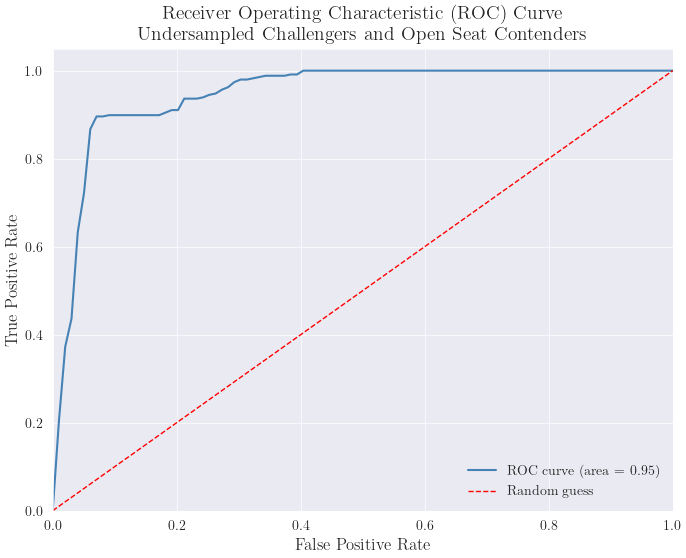

In [72]:
from scipy.interpolate import interp1d

fpr, tpr, thresholds = roc_curve(house_oc_smote['winner'], result.predict(house_oc_smote[['intercept','tot_rec', 'inc']]))
roc_auc = auc(fpr, tpr)
print(f'Area under the ROC curve: {roc_auc.round(3)}')

fpr_interp = np.linspace(0, 1, 100)
tpr_interp = interp1d(fpr, tpr, kind='linear')(fpr_interp)

with plt.style.context(['science']):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_interp, tpr_interp, label='ROC curve (area = {:.2f})'.format(roc_auc), color='#4682B4', linewidth=1.5)
    plt.plot([0, 1], [0, 1], label='Random guess', color='red', linestyle='--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.tick_params(axis='both', which='both', length=0)
    plt.title('Receiver Operating Characteristic (ROC) Curve\nUndersampled Challengers and Open Seat Contenders', fontsize=14)
    plt.legend(loc='lower right')
    plt.savefig('../../results/smaller-dataset/figures/roc_plot_logistic_regression_open_contenders_and_challengers_undersampled.png')
    plt.show()  

#### Summary

Taken together, the above tests and regression models provide strong evidence in favor of the research hypothesis that campaign contributions $C$ are predictive of electoral victory or defeat $W$, both as such and after controlling for the covariate of incumbency $I$, although as noted in the previous section, the three variables $C$, $I$, and $W$ exhibit subtler relationships than could be captured by the foregoing regressions.

In light of the abovementioned limitations inherent in the application of a multiple logistic regression model to a dataset with an imbalanced response variable, some non-linearity, and a preponderance of outliers in a continuous explanatory variable, it was determined that additional insight might be obtained by training and testing several more sophisticated machine learning models on the data, the majority of which require fewer or no such assumptions.

### Assessment of Linear Separability with Single-Layer Perceptron

Application of a single-layer perceptron to the untransformed data indicated low linear separability which was substantially ameliorated by application of both MinMaxScaler and RobustScaler.

#### Untransformed Data

In [73]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(random_state=137)

X = house[['inc','tot_rec']]

X = pd.get_dummies(X)

y = house['winner'].astype(int)

perceptron.fit(X, y)

Perceptron(random_state=137)

              precision    recall  f1-score   support

           0       0.01      1.00      0.03         5
           1       1.00      0.54      0.70       758

    accuracy                           0.54       763
   macro avg       0.51      0.77      0.36       763
weighted avg       0.99      0.54      0.70       763



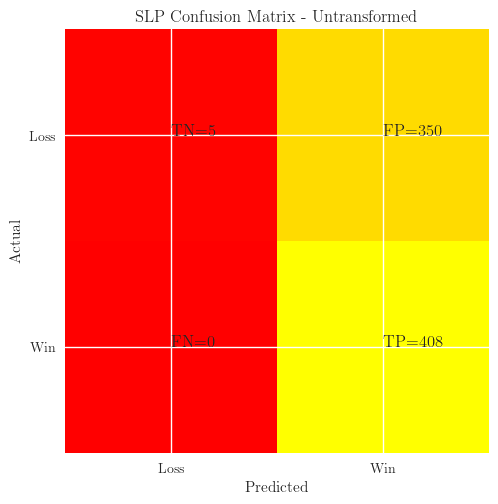

In [74]:
matrix = confusion_matrix(y, perceptron.predict(X))
 
plt.clf() 
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.autumn)

plt.title('SLP Confusion Matrix - Untransformed')
plt.ylabel('Actual')
plt.xlabel('Predicted')

target = ['Loss','Win']
ticks = [0,1]
plt.xticks(ticks, target)
plt.yticks(ticks, target)

labels = [['TN','FP'], ['FN', 'TP']]
  
for j in range(2):
    for k in range(2):
        plt.text(k,j, str(labels[j][k]) + '=' + str(matrix[j][k]))
        
print(classification_report(perceptron.predict(X), y))
plt.show()

#### Rescaled Data - MinMaxScaler

              precision    recall  f1-score   support

           0       0.97      0.86      0.92       399
           1       0.87      0.97      0.92       364

    accuracy                           0.92       763
   macro avg       0.92      0.92      0.92       763
weighted avg       0.92      0.92      0.92       763



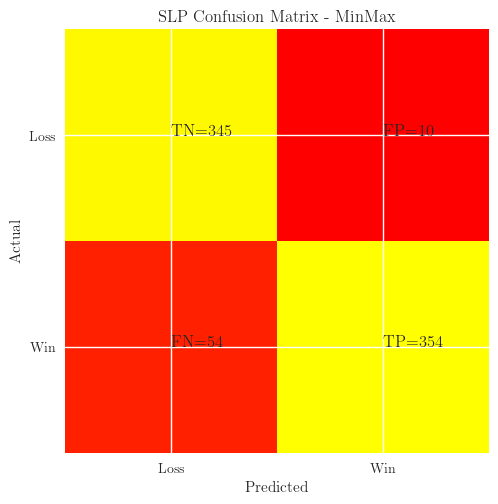

In [75]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

X_mm = minmax.fit_transform(X)

perceptron.fit(X_mm, y)

matrix = confusion_matrix(y, perceptron.predict(X_mm))

plt.clf() 
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.autumn)

plt.title('SLP Confusion Matrix - MinMax')
plt.ylabel('Actual')
plt.xlabel('Predicted')

target = ['Loss','Win']
ticks = [0,1]
plt.xticks(ticks, target)
plt.yticks(ticks, target)

labels = [['TN','FP'], ['FN', 'TP']]
  
for j in range(2):
    for k in range(2):
        plt.text(k,j, str(labels[j][k]) + '=' + str(matrix[j][k]))

print(classification_report(perceptron.predict(X_mm), y))
plt.show()

#### RobustScaler

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       404
           1       0.86      0.97      0.91       359

    accuracy                           0.91       763
   macro avg       0.92      0.92      0.91       763
weighted avg       0.92      0.91      0.91       763



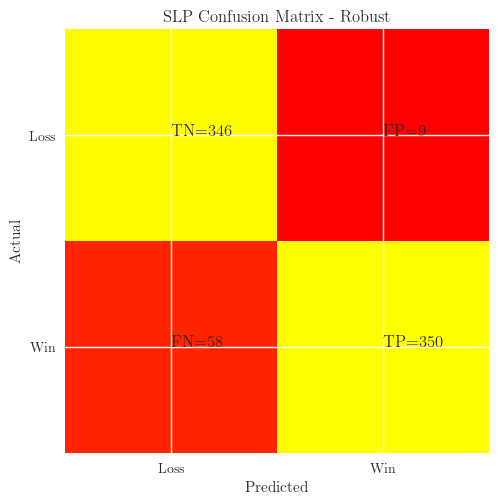

In [76]:
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()

X_rs = robust.fit_transform(X)

perceptron.fit(X_rs, y)

matrix = confusion_matrix(y, perceptron.predict(X_rs))

plt.clf() 
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.autumn)

plt.title('SLP Confusion Matrix - Robust')
plt.ylabel('Actual')
plt.xlabel('Predicted')

target = ['Loss','Win']
ticks = [0,1]
plt.xticks(ticks, target)
plt.yticks(ticks, target)

labels = [['TN','FP'], ['FN', 'TP']]
  
for j in range(2):
    for k in range(2):
        plt.text(k,j, str(labels[j][k]) + '=' + str(matrix[j][k]))

print(classification_report(perceptron.predict(X_rs), y))
plt.show()

### Algorithmic Classification and Electoral Outcome Prediction

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [78]:
def optimizer(algorithm, param_grid, X, y):
    
    alg = algorithm
    
    gs = GridSearchCV(algorithm, param_grid).fit(X, y)
    
    alg_opt = alg.set_params(**gs.best_params_)
    
    return alg_opt

#### Preprocessing

In [79]:
from sklearn.model_selection import train_test_split

X = house[['inc','tot_rec']]

X = pd.get_dummies(X)

y = house['winner'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=137)

minmax = MinMaxScaler()

X_train_mm = minmax.fit_transform(X_train)

X_test_mm = minmax.transform(X_test)

#### Logistic Regression

In [80]:
log_grid =  {'C':[0.001,0.01,0.1,1,5,7.5,10], 'class_weight':[None,'balanced'], 'penalty':['l1','l2']}

logreg = optimizer(LogisticRegression(), log_grid, X_train_mm, y_train)

logreg.fit(X_train_mm, y_train)

print(logreg.coef_, logreg.intercept_)

[[ 1.89904742 -2.71944704  2.99507571 -0.30191423]] [0.05212097]


In [81]:
print(classification_report(logreg.predict(X_test_mm), y_test))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       117
           1       0.95      0.95      0.95       112

    accuracy                           0.95       229
   macro avg       0.95      0.95      0.95       229
weighted avg       0.95      0.95      0.95       229



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

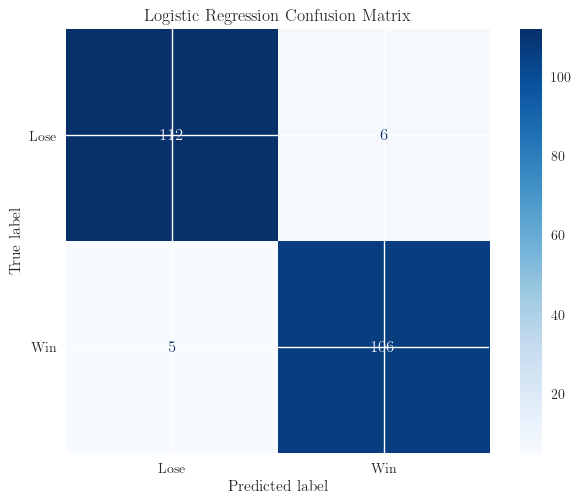

In [82]:
cm_logreg = confusion_matrix(y_test, logreg.predict(X_test_mm), labels=logreg.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=['Lose','Win']).plot(cmap=plt.cm.Blues)

plt.title('Logistic Regression Confusion Matrix')

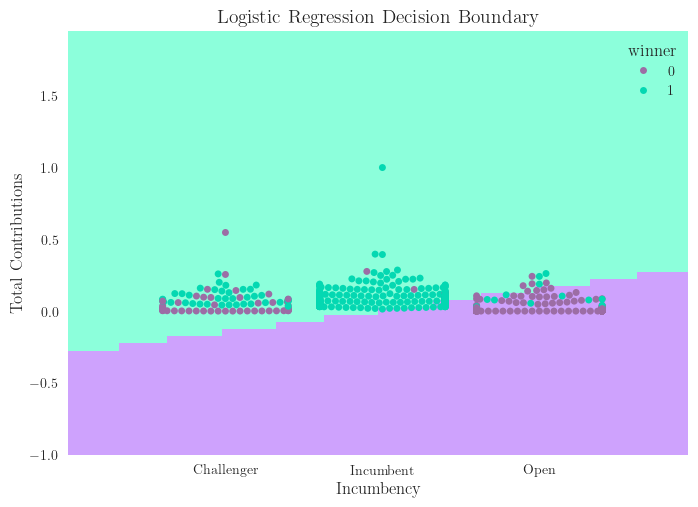

In [83]:
from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = LogisticRegression(C=5, class_weight='balanced', penalty='l2')
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Logistic Regression Decision Boundary', fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)
plt.savefig('../../results/smaller-dataset/figures/logistic_regression_decision_boundary.png')
plt.show()

#### K-Nearest Neighbor

In [84]:
knn_grid = {'n_neighbors':range(1,100)}

knn = optimizer(KNeighborsClassifier(), knn_grid, X_train_mm, y_train)

knn.fit(X_train_mm, y_train)

KNeighborsClassifier(n_neighbors=8)

In [85]:
print(classification_report(y_test, knn.predict(X_test_mm)))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       118
           1       0.92      0.97      0.94       111

    accuracy                           0.94       229
   macro avg       0.94      0.94      0.94       229
weighted avg       0.94      0.94      0.94       229



Text(0.5, 1.0, 'k-NN Confusion Matrix')

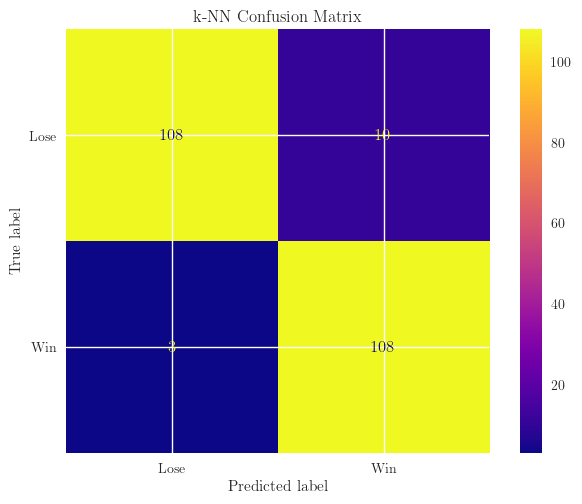

In [86]:
cm_knn = confusion_matrix(y_test, knn.predict(X_test_mm), labels=knn.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Lose','Win']).plot(cmap=plt.cm.plasma)

plt.title('k-NN Confusion Matrix')

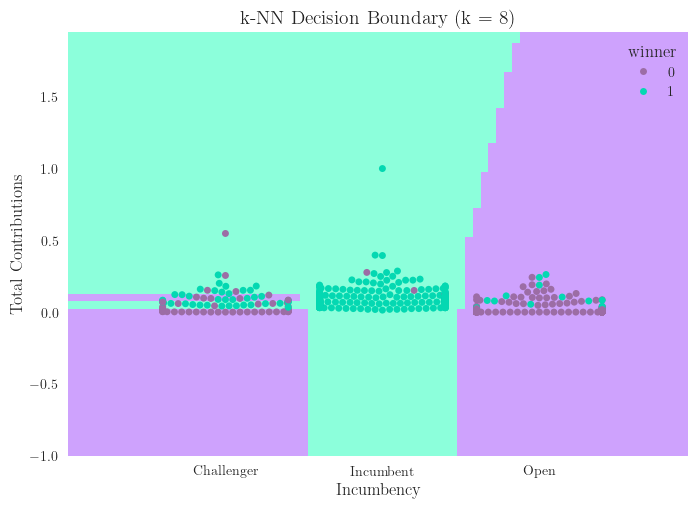

In [87]:
H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

opt_k = knn.get_params()['n_neighbors']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = KNeighborsClassifier(n_neighbors=opt_k)
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("k-NN Decision Boundary (k = {})".format(str(opt_k)), fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)
plt.savefig('../../results/smaller-dataset/figures/knn_decision_boundary.png')
plt.show()

#### Support Vector Machine

In [88]:
svc_grid = {'C':[0.01,0.1,0.25,0.5,0.75,1], 'kernel':['libear','rbf', 'sigmoid'],
            'gamma':['scale','auto']}

svc = optimizer(SVC(), svc_grid, X_train_mm, y_train)

svc.fit(X_train_mm, y_train)

SVC(C=1)

In [89]:
print(classification_report(svc.predict(X_test_mm), y_test))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       117
           1       0.95      0.95      0.95       112

    accuracy                           0.95       229
   macro avg       0.95      0.95      0.95       229
weighted avg       0.95      0.95      0.95       229



Text(0.5, 1.0, 'SVC Confusion Matrix')

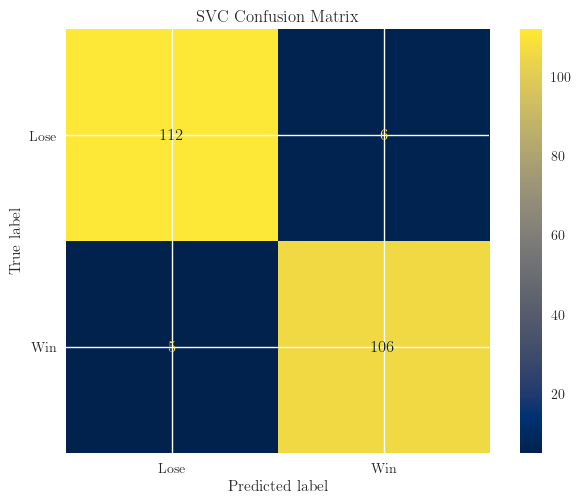

In [90]:
cm_svc = confusion_matrix(y_test, svc.predict(X_test_mm), labels=svc.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=['Lose','Win']).plot(cmap=plt.cm.cividis)

plt.title('SVC Confusion Matrix')

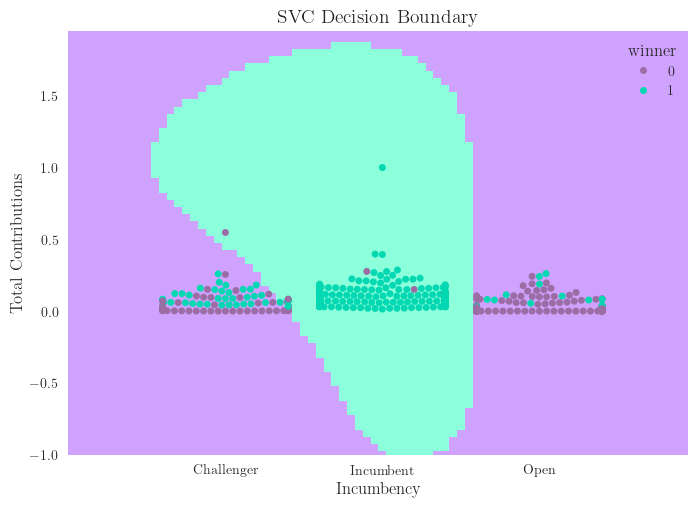

In [91]:
H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = svc
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("SVC Decision Boundary", fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)
plt.savefig('../../results/smaller-dataset/figures/svc_decision_boundary.png')
plt.show()


#### Decision Tree

In [92]:
tree_grid = {'criterion':['gini','entropy','log_loss'], 'max_depth':range(2,10), 'ccp_alpha': [0.1,0.01,0.001,0]}

tree = optimizer(DecisionTreeClassifier(), tree_grid, X_train_mm, y_train)

tree.fit(X_train_mm, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=3)

In [93]:
print(classification_report(tree.predict(X_test_mm), y_test))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       110
           1       0.97      0.91      0.94       119

    accuracy                           0.94       229
   macro avg       0.94      0.94      0.94       229
weighted avg       0.94      0.94      0.94       229



Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

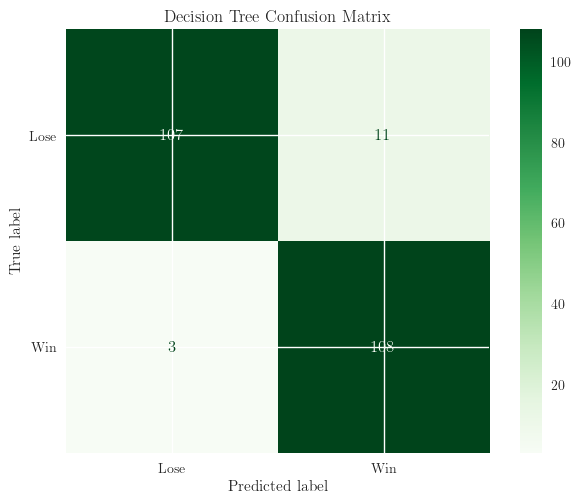

In [94]:
cm_tree = confusion_matrix(y_test, tree.predict(X_test_mm), labels=tree.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=['Lose','Win']).plot(cmap=plt.cm.Greens)

plt.title('Decision Tree Confusion Matrix')

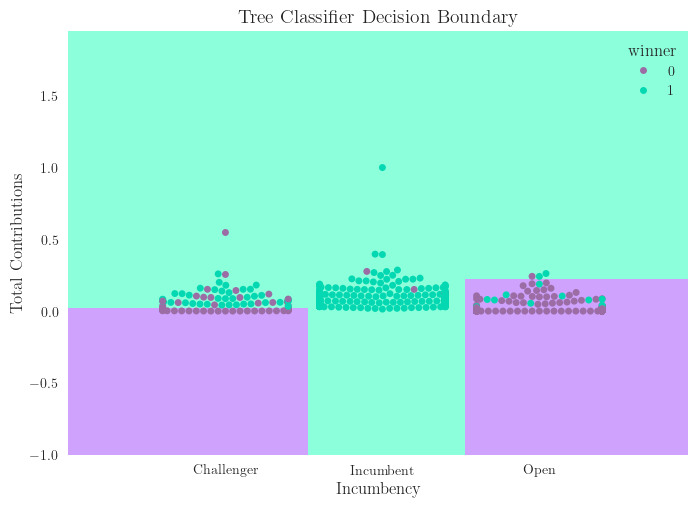

In [95]:
H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = tree
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Tree Classifier Decision Boundary", fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)
plt.savefig('../../results/smaller-dataset/figures/tree_classifier_decision_boundary.png')
plt.show()


## Multilayer Perceptron

In [96]:
mlp_grid = {'hidden_layer_sizes':[(j,j,j) for j in range(10,30,10)], 'activation':['indentity','logistic','tanh','relu'], 
            'solver':['lbfgs','sgd','adam']}

mlp = optimizer(MLPClassifier(random_state=137), mlp_grid, X_train_mm, y_train)

mlp.fit(X_train_mm, y_train)

MLPClassifier(hidden_layer_sizes=(20, 20, 20), random_state=137, solver='lbfgs')

In [97]:
print(classification_report(mlp.predict(X_test_mm), y_test))

report_dict = classification_report(y_test, mlp.predict(X_test_mm), output_dict=True)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       111
           1       0.96      0.91      0.93       118

    accuracy                           0.93       229
   macro avg       0.94      0.94      0.93       229
weighted avg       0.94      0.93      0.93       229



Text(0.5, 1.0, 'Triple-Layer Perceptron Confusion Matrix')

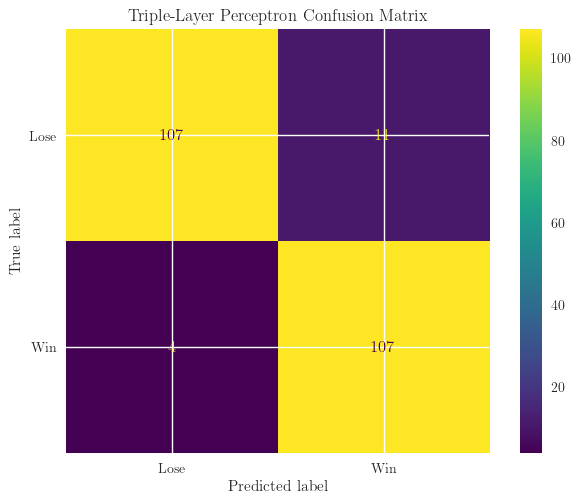

In [98]:
cm_mlp = confusion_matrix(y_test, mlp.predict(X_test_mm), labels=mlp.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=['Lose','Win']).plot(cmap=plt.cm.viridis)

plt.title('Triple-Layer Perceptron Confusion Matrix')

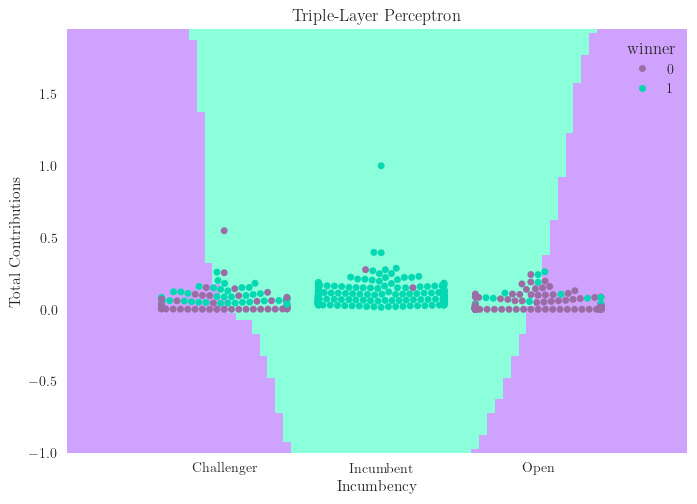

In [99]:
H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = MLPClassifier(hidden_layer_sizes=(10,10,10), activation='logistic', solver='lbfgs', random_state=137)
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Triple-Layer Perceptron')
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency')
plt.ylabel('Total Contributions')
plt.savefig('../../results/smaller-dataset/figures/perceptron_decision_boundary.png')
plt.show()